In [1]:
import os
import glob
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
%matplotlib inline
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
matplotlib.rcParams.update({'font.size':15})

import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/pscratch/sd/q/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

import tools.generalTools as gt
import tools.e5tools as e5
import tropicalOrographicRegions.mountainUtils as mu

from scipy.stats import linregress
from scipy.ndimage import gaussian_filter
from scipy.integrate import cumtrapz

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.lines

%load_ext autoreload
%autoreload 2

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
import dask
from dask.distributed import Client, LocalCluster

dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{host}:{port}/status"

client = Client(n_workers=8,threads_per_worker=1,memory_limit='10G')
client

<Client: 'tcp://127.0.0.1:42797' processes=8 threads=8, memory=74.51 GiB>

# Data

## Observations

In [51]:
def sel_box_months(var,box,months,lon='longitude',lat='latitude',lat_increase=False):
    window = sel_box(var,box,lon,lat,lat_increase)
    window=sel_months(window,months)
    return window

def add_wind(ax,u,v,color='k',width=0.001,scale=600,key=True,ref=10,unit='m/s',pos=(0.87,1.03),nm=5,fontproperties=None):
    ax.coastlines()
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = v.longitude.expand_dims({"latitude":u.latitude})
    n=nm
    m=nm
    q=ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color=color,width=width,scale=scale)
    if key:
        ax.quiverkey(q, *pos, ref, label='%i %s'%(ref,unit), labelpos='E', coordinates='axes',color='k',fontproperties=fontproperties)
    return q

def add_latlon(ax,box,ftz=None):
    ax.set_anchor('W')
    dl=5
    lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
    lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
    
    ax.set_xticks(lons, crs=ccrs.PlateCarree())
    ax.set_yticks(lats, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    if ftz:
        ax.tick_params(axis='both', which='major', labelsize=ftz)
    
    ax.set_xlabel("")
    ax.set_ylabel("")

def reorder(da):
    da.coords['longitude'] = da.coords['longitude'] % 360
    da = da.sortby(da.longitude)
    return da.reindex(latitude=list(reversed(da.latitude)))
 
def smooth(ds):
    return xr.apply_ufunc(gaussian_filter,ds,kwargs={"sigma":2.})

class PrecipDataset :
    def __init__(self, data, name):
        self.name=name
        self.precip=data
        self.resolution = ("%.3f"%float(data.longitude[1]-data.longitude[0])).rstrip('0')+"°"
        self.time_range = (pd.to_datetime(data.time.min().values).strftime("%Y-%m"),pd.to_datetime(data.time.max().values).strftime("%Y-%m"))
        

In [4]:
box = [60,135,-5,30]

In [5]:
topo_hires = xr.open_dataset("/pscratch/sd/q/qnicolas/ETOPO1_Ice_g_gmt4.grd").z.rename({'x':'longitude','y':'latitude'})
topo_hires = topo_hires.reindex(latitude=list(reversed(topo_hires.latitude)))
topo_hires.coords['longitude'] = topo_hires.coords['longitude'] % 360
topo_hires = topo_hires.sortby(topo_hires.longitude)
orogm = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81
lsm = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM.isel(time=0)

In [6]:
aphrodite_path = "/global/cfs/projectdirs/m3310/qnicolas/APHRODITE/"
aphrodite_1 = xr.open_dataset(aphrodite_path+"APHRO_MA_025deg_V1101.1951-2007.monthly.nc")
aphrodite_2 = xr.open_dataset(aphrodite_path+"APHRO_MA_025deg_V1101_EXR1.2007-2015.monthly.nc")
aphrodite_monthly = reorder(xr.concat((aphrodite_1.precip.sel(time=(aphrodite_1['time.year']<2007)),\
                                       aphrodite_2.precip.rename({'lat':'latitude','lon':'longitude'})),\
                                      dim='time'))

In [7]:
#e5_pr_monthly = 1e3*e5_monthly_timeseries('128_228_tp',range(1979,2021))
e5_pr_monthly_1979_2020 = xr.open_zarr("/pscratch/sd/q/qnicolas/temp/e5.climatology.TP.1979-2020.zarr").TP*1e3
e5_pr_monthly_1950_1978 = 1e3*e5.e5_monthly_timeseries('128_228_tp',range(1950,1979))
e5_pr_monthly = xr.concat((e5_pr_monthly_1950_1978,e5_pr_monthly_1979_2020),dim='time')

2.257014751434326


In [8]:
APHRODITE = PrecipDataset(aphrodite_monthly,'APHRODITE')
ERA5      = PrecipDataset(e5_pr_monthly,'ERA5 precip')
datasets = (APHRODITE, ERA5 )

In [9]:
%%time
for dataset in datasets:
    dataset.precip_seasonal_yearly = {}
    for monthgroup in (6,7,8),(10,11,12),(11,12):
        dataset.precip_seasonal_yearly[monthgroup] = gt.sel_box_months(dataset.precip,box = box, months=monthgroup).groupby('time.year').mean().load()

CPU times: user 2.16 s, sys: 916 ms, total: 3.08 s
Wall time: 7.52 s


In [10]:
for dataset in datasets:
    dataset.lsm = lsm.interp_like(dataset.precip_seasonal_yearly[(11,12)])>0.1

In [11]:
%%time
e5_100u_1979_2020 = e5.e5_monthly_timeseries('228_246_100u',range(1979,2021))
e5_100v_1979_2020 = e5.e5_monthly_timeseries('228_247_100v',range(1979,2021))
e5_100u_1950_1978 = e5.e5_monthly_timeseries('228_246_100u',range(1950,1979))
e5_100v_1950_1978 = e5.e5_monthly_timeseries('228_247_100v',range(1950,1979))

e5_100u_monthly = xr.concat((e5_100u_1950_1978,e5_100u_1979_2020),dim='time')
e5_100v_monthly = xr.concat((e5_100v_1950_1978,e5_100v_1979_2020),dim='time')

e5_100u_seasonal_yearly = {}
e5_100v_seasonal_yearly = {}
for monthgroup in (6,7,8),(10,11,12),(11,12):
    e5_100u_seasonal_yearly[monthgroup] = gt.sel_box_months(e5_100u_monthly,box = box, months=monthgroup).groupby('time.year').mean().load()
    e5_100v_seasonal_yearly[monthgroup] = gt.sel_box_months(e5_100v_monthly,box = box, months=monthgroup).groupby('time.year').mean().load()


4.469864368438721
5.003249406814575
2.6326701641082764
2.693298816680908
CPU times: user 12.7 s, sys: 5.33 s, total: 18 s
Wall time: 43.4 s


In [12]:
class MountainRangeSimple():
    def __init__(self,name, box,months, tilted_rect,angle,P0,Lname=''):
        self.name = name
        self.Lname = Lname
        self.box = box
        self.tilted_rect = tilted_rect
        self.angle = angle
        self.P0=P0
        self.months = months
        self._monthstr = '-'.join(["{:02}".format(m) for m in self.months])
        self.vars={}
        self.vars['U100_DAILY'] = xr.open_dataarray("/pscratch/sd/q/qnicolas/regionsDataBig/e5.oper.an.sfc.228_246_100u.ll025sc.2001-2020.{}.{}.nc".format(self._monthstr,self.name))
        self.vars['V100_DAILY'] = xr.open_dataarray("/pscratch/sd/q/qnicolas/regionsDataBig/e5.oper.an.sfc.228_247_100v.ll025sc.2001-2020.{}.{}.nc".format(self._monthstr,self.name))
        self.vars['IMERG_DAILY'] = xr.open_dataarray("/pscratch/sd/q/qnicolas/regionsDataBig/gpm_imerg_v06.2001-2020.{}.{}.nc".format(self._monthstr,self.name))

        imerg_lsm = lsm.interp_like(self.vars['IMERG_DAILY'])>0.1
        mask_above_imerg = imerg_lsm * mu.tilted_rect(self.vars['IMERG_DAILY'],*self.tilted_rect,reverse=False)
        mask_upstream_imerg = mu.tilted_rect_distance(self.vars['IMERG_DAILY'],*self.tilted_rect[:-1],-2,-4)
        mask_wind_era5 = mu.tilted_rect(self.vars['U100_DAILY'],*self.tilted_rect,reverse=True)
        
        self.vars['IMERG_DAILY_ABOVE'] = gt.spatial_mean(self.vars['IMERG_DAILY'],mask=mask_above_imerg,box=None)
        self.vars['IMERG_DAILY_UPSTREAM'] = gt.spatial_mean(self.vars['IMERG_DAILY'],mask=mask_upstream_imerg,box=None)
        self.vars['U100_DAILY_BOXWIND'] = gt.spatial_mean(self.vars['U100_DAILY'],mask=mask_wind_era5,box=None)
        self.vars['V100_DAILY_BOXWIND'] = gt.spatial_mean(self.vars['V100_DAILY'],mask=mask_wind_era5,box=None)
        
Ghats = MountainRangeSimple      ('ghats'      ,[67, 91, 5.5, 27],[6,7,8]   ,[75, 9, 71.5, 20,2]              ,70  ,3 , Lname='Western Ghats')
Myanmar = MountainRangeSimple    ('myanmar'    ,[82,102,5.5,27]  ,[6,7,8]   ,[94.2, 16.5,  91.4  , 21.5 , 1.5],50  ,6 , Lname='Myanmar')#[94.5, 17,  91.5  , 21.5 , 1.5], [94, 15,  91  , 21.5 , 2]
Vietnam = MountainRangeSimple    ('vietnam'    ,[100,118,8,25]   ,[10,11,12],[108  ,  18  , 111  , 13   ,2]   ,240 ,4 , Lname='Vietnam')#[108, 18, 110, 15, 2]
Philippines = MountainRangeSimple('philippines',[118,135,5,22]   ,[11,12]   ,[122.5, 19, 127, 9, 2]           ,225 ,10, Lname='Philippines')
Malaysia = MountainRangeSimple   ('malaysia'   ,[95,115,-2,15]   ,[11,12]   ,[102.5,   8  , 105.5,  3   ,2]   ,225 ,4 , Lname='Malaysia')
MRs = (Ghats,Myanmar,Vietnam,Philippines,Malaysia)

for dataset in datasets:
    dataset.region_masks = {}
    for MR in MRs:
        dataset.region_masks[MR.name] = gt.sel_box(dataset.lsm*mu.tilted_rect(dataset.lsm,*MR.tilted_rect),box)

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


## Simulations

In [3]:
from tools.wrfHrTools import Simulation,change_coords_pl

In [4]:
import orographicConvectionTheory.orographicConvectionTheory as orog 
xx,hx=orog.topographic_profile('cos',A=500.)

In [5]:
def upstream_mean(ds,reverse=False):
    if reverse:
        return ds.sel(distance_from_mtn=slice(-4000,-2500)).mean('distance_from_mtn')
    else:
        return ds.sel(distance_from_mtn=slice(-2500,-4000)).mean('distance_from_mtn')
    
def prime(ds,reverse=False):
    return ds - upstream_mean(ds,reverse)

def averageB(ds,psfc,ptop=850):
    ds = ds.bfill(dim='pressure')
    p1 = 990;p2=ptop
    part1 = -ds.sel(pressure=slice(p1,p2)).integrate('pressure')
    part2 = ds.sel(pressure=p1)*(psfc-990)
    return ((part1+part2)/(psfc-ptop))
def averageL(ds,p1 = 850,p2 = 500):
    return (-ds.sel(pressure=slice(p1,p2)).integrate('pressure')/(p1-p2))

class SimulationCustom2(Simulation):
    def __init__(self,path,center,dx,suffix2,inp=False,out=False,pout=False,is_subset=False):
        super().__init__(path,center,dx,inp,out,pout,is_subset)
        self.suffix2 = suffix2
        self.RAINNC_MEAN = xr.open_dataarray(self.path+'wrf.RAINNC.ALLMEAN.nc')
        RAINNC_DAILY = xr.open_zarr(self.path+'wrf.RAINNC.1h.ALL_CONCAT.zarr').RAINNC_MMDY.mean('south_north').coarsen(Time=24).mean()
        self.RAINNC_DAILY = RAINNC_DAILY
        self.RAINNC_STERR = 2 * RAINNC_DAILY.std('Time').load() / np.sqrt(len(RAINNC_DAILY.Time))
        
        self.T_PL_MEAN = xr.open_dataarray(self.path+'wrf.T_PL.ALLMEAN.nc')
        self.Q_PL_MEAN = xr.open_dataarray(self.path+'wrf.Q_PL.ALLMEAN.nc')
        self.W_PL_MEAN = xr.open_dataarray(self.path+'wrf.W_PL.ALLMEAN.nc')

W10S300   = SimulationCustom2('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/'          ,1635,3,'1970010100-1970072000',inp=True)
W12S300   = SimulationCustom2('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/'          ,1635,3,'1970010100-1971010400',inp=True)   

In [128]:
W10S300.color='c'
W12S300.color='blue'

W10S300.color2='limegreen'
W12S300.color2='darkgreen'

W10S300.label=r'$U = 10$ m$\,$s$^{-1}$'
W12S300.label=r'$U = 12$ m$\,$s$^{-1}$'

In [7]:
for Sim in W10S300 , W12S300:
    Sim.PSFC_MEAN = xr.open_zarr(Sim.path + "wrf.PSFC_INTERP.1h.%s.zarr"%Sim.suffix2).PSFC[-480:].mean(('Time','south_north')).load()
    Sim.THETAE_MEAN = xr.open_dataarray(Sim.path + "wrf.THETAE.ALLMEAN.nc")
    
    Sim.U_PL_MEAN = xr.open_dataarray(Sim.path+'wrf.U_PL.ALLMEAN.nc')
    Sim.OMEGA_PL_MEAN = -Sim.T_PL_MEAN.pressure*100/(287. * Sim.T_PL_MEAN) * 9.81 * Sim.W_PL_MEAN
    udthetaedx = -(Sim.U_PL_MEAN*Sim.THETAE_MEAN.differentiate('distance_from_mtn')/1000 * 86400)
    omegadthetaedp = (Sim.OMEGA_PL_MEAN*Sim.THETAE_MEAN.differentiate('pressure')/100 * 86400)
    Qthetae = udthetaedx+omegadthetaedp
    Sim.OMEGADTHETAEDP = omegadthetaedp
    
    omegadthetaedp = (Sim.OMEGA_PL_MEAN*upstream_mean(W10S300.THETAE_MEAN).differentiate('pressure')/100 * 86400)
    Sim.OMEGADTHETAE0DP = omegadthetaedp
    
    Sim.QTHETAE = Qthetae

# Theory + Simulation

## No damping

In [103]:
def linear_zeta(h,N,U,x,z):
    k=orog.k_vector(len(x),x[1]-x[0])
    zetahat = np.fft.fft(h)[:,None]*np.exp( orog.m_exponent(k[:,None],N,U)  *  z[None,:])
    Tz = 300. + (300.*N**2/9.81 - 9.81/1004.)*z
    lnpz = - cumtrapz(9.81/(287.*Tz),z,initial=0.)
    zeta=xr.DataArray(np.real(np.fft.ifft(zetahat,axis=0)),coords={'x':x/1e3,'z':z,'p':('z',1000.*np.exp(lnpz))},dims={'x':x/1e3,'z':z})
    return zeta


def linear_precip_theory(xx,hx,U,tauT=7.5 * 3600,tauq=27.5 * 3600,N=0.01,switch=1,zbot=1000,ztop=3000):
    pT_ov_g = 8e3 #mass of troposphere in kg/m2
    Lv = 2.5e6; cp=1004.; g = 9.81
    
    z=np.arange(zbot,ztop+1,50)
    k=orog.k_vector(len(xx),xx[1]-xx[0])

    Lq=orog.compute_Lq(5,U,tauq)
    
    ds0dz = 300./g * N**2 * cp
    dq0dz = 2.5e6 * np.gradient(0.015 * np.exp(-z/2500),z).mean()
    
    chi = pT_ov_g * (ds0dz/tauT - dq0dz/tauq)/ Lv * 86400
    
    Pprimehat = 1j*k/(1j*k + switch*1/Lq) * np.fft.fft(hx) * (chi *np.exp( orog.m_exponent(k[:,None],N,U)  *  z[None,:])).mean(axis=1) 
    
    P = np.real(np.fft.ifft(Pprimehat))
    return P

In [104]:
xx,hx = orog.topographic_profile('cos',A=500)
zz = np.arange(0.,21e3,100.)
zeta_10 = linear_zeta(hx,0.01,10.,xx,zz)
zeta_12 = linear_zeta(hx,0.01,12.,xx,zz)

In [105]:
Pp_10 = linear_precip_theory(xx,hx,10,ztop=3000)
Pp_12 = linear_precip_theory(xx,hx,12,ztop=3000)
Pd_10 = linear_precip_theory(xx,hx,10,ztop=3000,switch=1e-4)
Pd_12 = linear_precip_theory(xx,hx,12,ztop=3000,switch=1e-4)

In [106]:
(Pp_12.max()/Pp_10.max()-1)*50

19.193516867253145

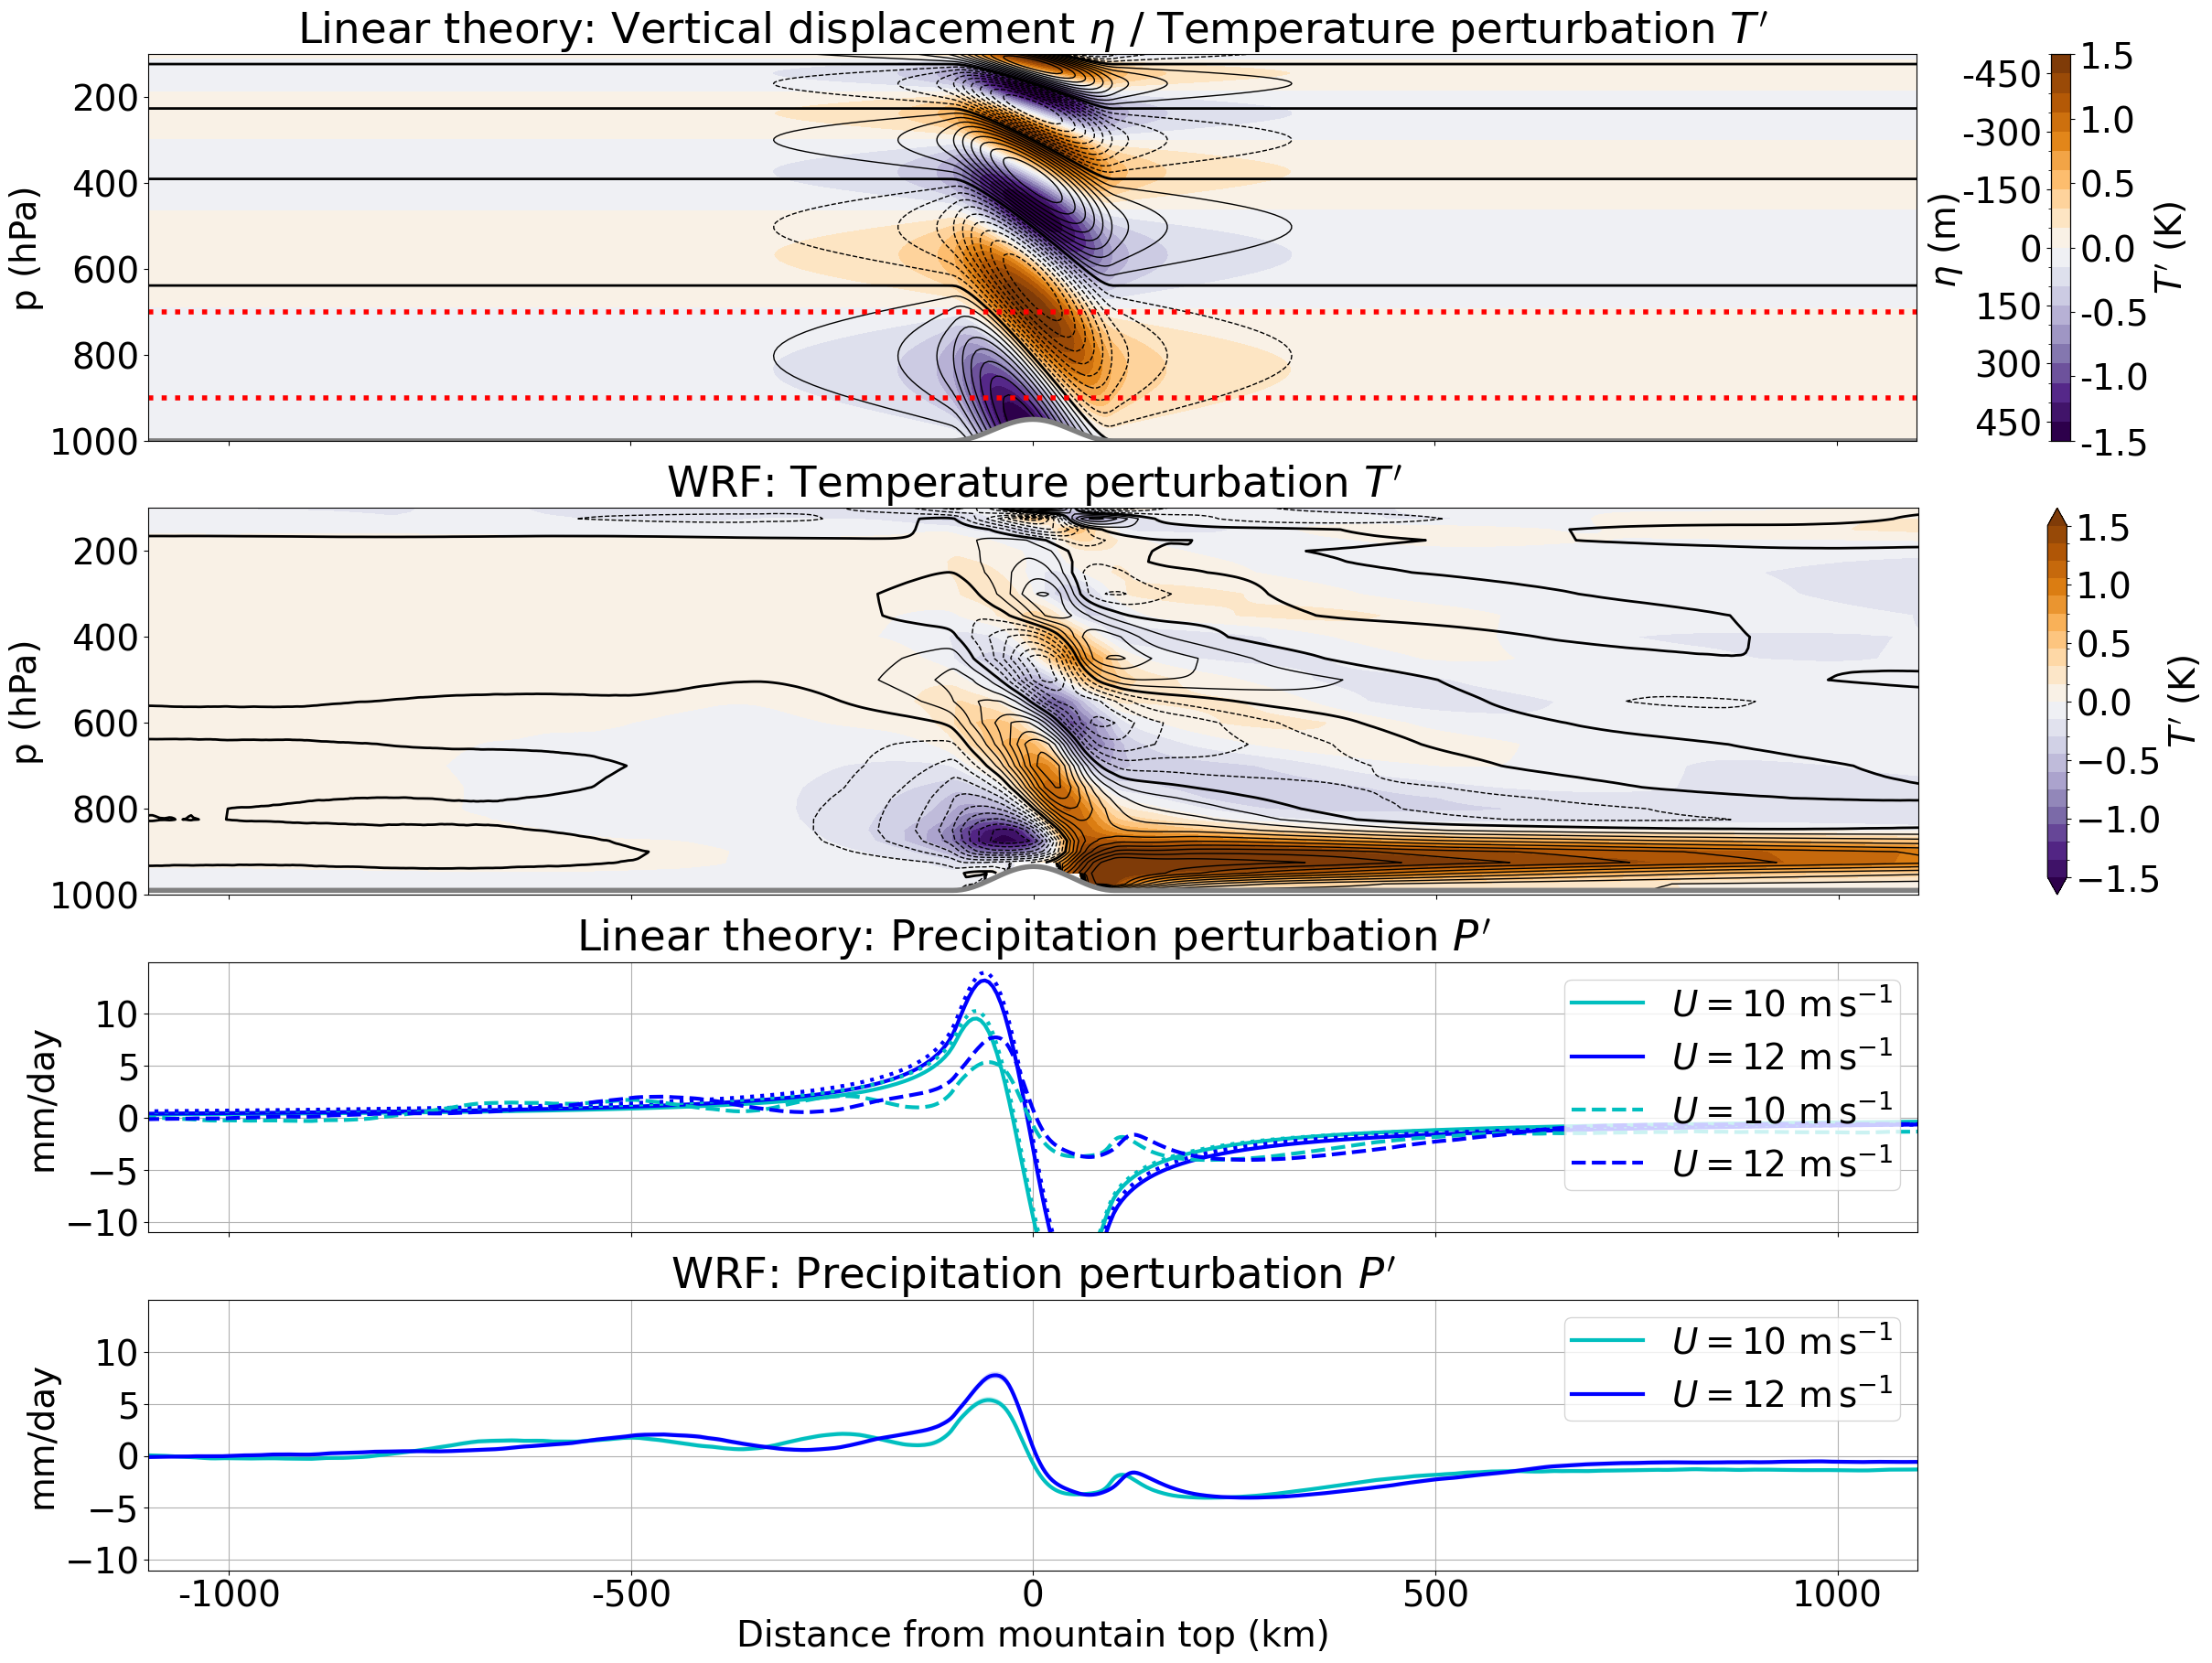

In [107]:
matplotlib.rcParams.update({'font.size': 28})
fig,(ax,axw,ax2,axw2)=plt.subplots(4,1,figsize=(24,18),height_ratios=(1,1,0.7,0.7))


#### FIRST PLOT - eta in linear theory####
levs = np.linspace(-500,500,21)
cbticks = np.arange(-450,451,150) # eta valeus
T_ticks = np.arange(-1.5,1.6,0.5)  # T' values
n=len(levs)

im = (zeta_10).swap_dims(z='p').plot.contourf(ax=ax, y='p',levels=levs,cmap = plt.cm.PuOr,add_colorbar=False)
zeta_12.swap_dims(z='p').plot.contour (ax=ax, y='p',levels=levs,colors=['k']*n,linestyles=['--']*(n//2)+['-']*(n//2+1),linewidths=[1]*(n//2) + [2.] + [1]*(n//2))

# Make the colorbar
ds0dz = (300.*0.01**2/9.81)
colorbar = plt.colorbar(im,label='',pad=0.07,fraction=0.01)
# Add left ticks
#colorbar.ax.minorticks_off()
colorbar.ax.set_yticks(cbticks)
colorbar.ax.set_yticklabels(cbticks)
colorbar.ax.set_ylim(levs[-1],levs[0])
colorbar.ax.text(-6.5,0.42,r"$\eta$ (m)",transform=colorbar.ax.transAxes,rotation='vertical')
# Add right ticks
secondary_axis = colorbar.ax.twinx()
secondary_axis.set_yticks(T_ticks/ds0dz)
secondary_axis.set_yticklabels(T_ticks)
secondary_axis.set_ylabel(r"$T'$ (K)")

# fill white space
xplot=zeta_10.x
ax.fill_between(xplot,1000*xplot**0,1000*xplot**0 - hx*0.1,color='w',zorder=2)
ax.plot(xplot,1000-hx/10,color='gray',linewidth=4)

ax.axhline(900.,color='r',linestyle=':',linewidth=4)
ax.axhline(700.,color='r',linestyle=':',linewidth=4)



#### SECOND PLOT - T' in WRF####

levs = np.linspace(-1.5,1.5,21)
n=len(levs)

im = prime(W10S300.T_PL_MEAN).plot.contourf(ax=axw,y='pressure',yincrease=False,levels=levs,cmap=plt.cm.PuOr_r,extend='both',add_colorbar=False)
prime(W12S300.T_PL_MEAN).plot.contour (ax=axw,y='pressure',yincrease=False,levels=levs,colors='k',linestyles=['--']*(n//2)+['-']*(n//2+1),linewidths=[1]*(n//2) + [2.] + [1]*(n//2))
colorbar = plt.colorbar(im,label=r"$T'$ (K)",pad=0.067,fraction=0.012,ticks=T_ticks)

# fill white space
axw.fill_between(xplot,990*xplot**0,990 - hx/9,color='w',zorder=2)
axw.plot(xplot,990 - hx/9,color='gray',linewidth=4)

#### THIRD PLOT - precip in linear theory ####

ax2.plot(xplot,Pp_10,color='c',linewidth=3,label=r"$U=$10 m$\,$s$^{-1}$")
ax2.plot(xplot,Pp_12,color='b',linewidth=3,label=r"$U=$12 m$\,$s$^{-1}$")
ax2.plot(xplot,Pd_10,color='c',linewidth=3,linestyle=':')
ax2.plot(xplot,Pd_12,color='b',linewidth=3,linestyle=':')

#### FOURTH PLOT - precip in WRF ####
for Sim in (W10S300,W12S300):
    prime(Sim.RAINNC_MEAN).plot(ax=axw2,color=Sim.color,label=Sim.label,linewidth=3)
    axw2.fill_between(Sim.RAINNC_MEAN.distance_from_mtn,prime(Sim.RAINNC_MEAN)-Sim.RAINNC_STERR,prime(Sim.RAINNC_MEAN)+Sim.RAINNC_STERR,alpha=0.1,color=Sim.color)
    prime(Sim.RAINNC_MEAN).plot(ax=ax2,color=Sim.color,label=Sim.label,linewidth=3,linestyle='--')
    
#### COMMON settings ####
for a in ax2,axw2:
    divider2 = make_axes_locatable(a)
    cax2 = divider2.append_axes("right", size=1., pad=.67,axes_class=plt.Axes)
    cax2.remove()
    a.grid()
    
    a.set_ylim(-11,15)
    a.set_ylabel("mm/day")
    yticks=np.arange(-10,11,5)
    a.set_yticks(yticks)
    a.legend(loc=1,borderpad=0.2,fontsize=28)
for a in ax,axw:
    a.set_ylim(1000.,100)
    a.set_ylabel('p (hPa)')
    
ticks = np.arange(-1000,1100,500)
for a in ax,axw,ax2,axw2:
    a.set_xlim(-1100,1100)
    a.set_xticks(ticks)
    a.set_xticklabels('')
    a.set_xlabel('')
axw2.set_xticklabels(ticks)
axw2.set_xlabel('Distance from mountain top (km)')



ax.set_title(r"Linear theory: Vertical displacement $\eta$ / Temperature perturbation $T'$")
axw.set_title(r"WRF: Temperature perturbation $T'$")
ax2.set_title(r"Linear theory: Precipitation perturbation $P'$")
axw2.set_title(r"WRF: Precipitation perturbation $P'$")
fig.tight_layout(pad=0.02)

## with damping

In [234]:
def m_exponent_damped(k,N,U,eps):
    lz2 = N**2/U**2/(1-1j*eps/(k*U))
    m1 = (np.real(lz2) < k**2 ) * 1j*np.sqrt(k**2-lz2 + 0.j) 
    m2 = (np.real(lz2) >= k**2) * np.sign(k)*np.sqrt(lz2-k**2 + 0.j)
    return 1j * (m1 + m2)

def linear_zeta_damped(h,N,U,x,z,eps=1./86400.):
    k=orog.k_vector(len(x),x[1]-x[0]); k[0] = 1e-10 # dummy nonzero value
    h_hat = np.fft.fft(hx); h_hat[0] = 0.
    zetahat = h_hat[:,None]*np.exp( m_exponent_damped(k[:,None],N,U,eps)  *  z[None,:])
    Tz = 300. + (300.*N**2/9.81 - 9.81/1004.)*z
    lnpz = - cumtrapz(9.81/(287.*Tz),z,initial=0.)
    zeta=xr.DataArray(np.real(np.fft.ifft(zetahat,axis=0)),coords={'x':x/1e3,'z':z,'p':('z',1000.*np.exp(lnpz))},dims={'x':x/1e3,'z':z})
    return zeta


def linear_precip_theory_damped(xx,hx,N,U,eps=1./86400.,tauT=7.5 * 3600,tauq=27.5 * 3600,switch=1,zbot=1000,ztop=4000):
    pT_ov_g = 8e3 #mass of troposphere in kg/m2
    Lv = 2.5e6; cp=1004.; g = 9.81
    
    z=np.arange(zbot,ztop+1,10.)
    k=orog.k_vector(len(xx),xx[1]-xx[0]); k[0] = 1e-10 # dummy nonzero value
    h_hat = np.fft.fft(hx); h_hat[0] = 0.

    Lq=orog.compute_Lq(5,U,tauq)
    
    ds0dz = 300./g * N**2 * cp
    dq0dz = Lv * np.gradient(0.015 * np.exp(-z/2500),z)#.mean()
    
    chi = pT_ov_g * (ds0dz/tauT - dq0dz/tauq)/ Lv * 86400
    
    #Pprimehat = 1j*k/(1j*k + switch*1/Lq) * chi * h_hat * np.exp( m_exponent_damped(k[:,None],N,U,eps)  *  z[None,:]).mean(axis=1) 
    Pprimehat = 1j*k/(1j*k + switch*1/Lq)* h_hat * (chi * np.exp( m_exponent_damped(k[:,None],N,U,eps)  *  z[None,:])).mean(axis=1) 
    
    P = np.real(np.fft.ifft(Pprimehat))
    return P

In [235]:
xx,hx = orog.topographic_profile('cos',A=500)
zz = np.arange(0.,21e3,100.)
zeta_10 = linear_zeta_damped(hx,0.01,10.,xx,zz)
zeta_12 = linear_zeta_damped(hx,0.01,12.,xx,zz)

In [236]:
Pp_10 = linear_precip_theory_damped(xx,hx,0.01,10,ztop=4000)
Pp_12 = linear_precip_theory_damped(xx,hx,0.01,12,ztop=4000)
Pd_10 = linear_precip_theory_damped(xx,hx,0.01,10,ztop=4000,switch=1e-4)
Pd_12 = linear_precip_theory_damped(xx,hx,0.01,12,ztop=4000,switch=1e-4)

In [237]:
(Pp_12.max()/Pp_10.max() - 1) * 50

27.480485547733334

In [238]:
(Pd_12.max()/Pd_10.max() - 1) * 50

25.284101543469607

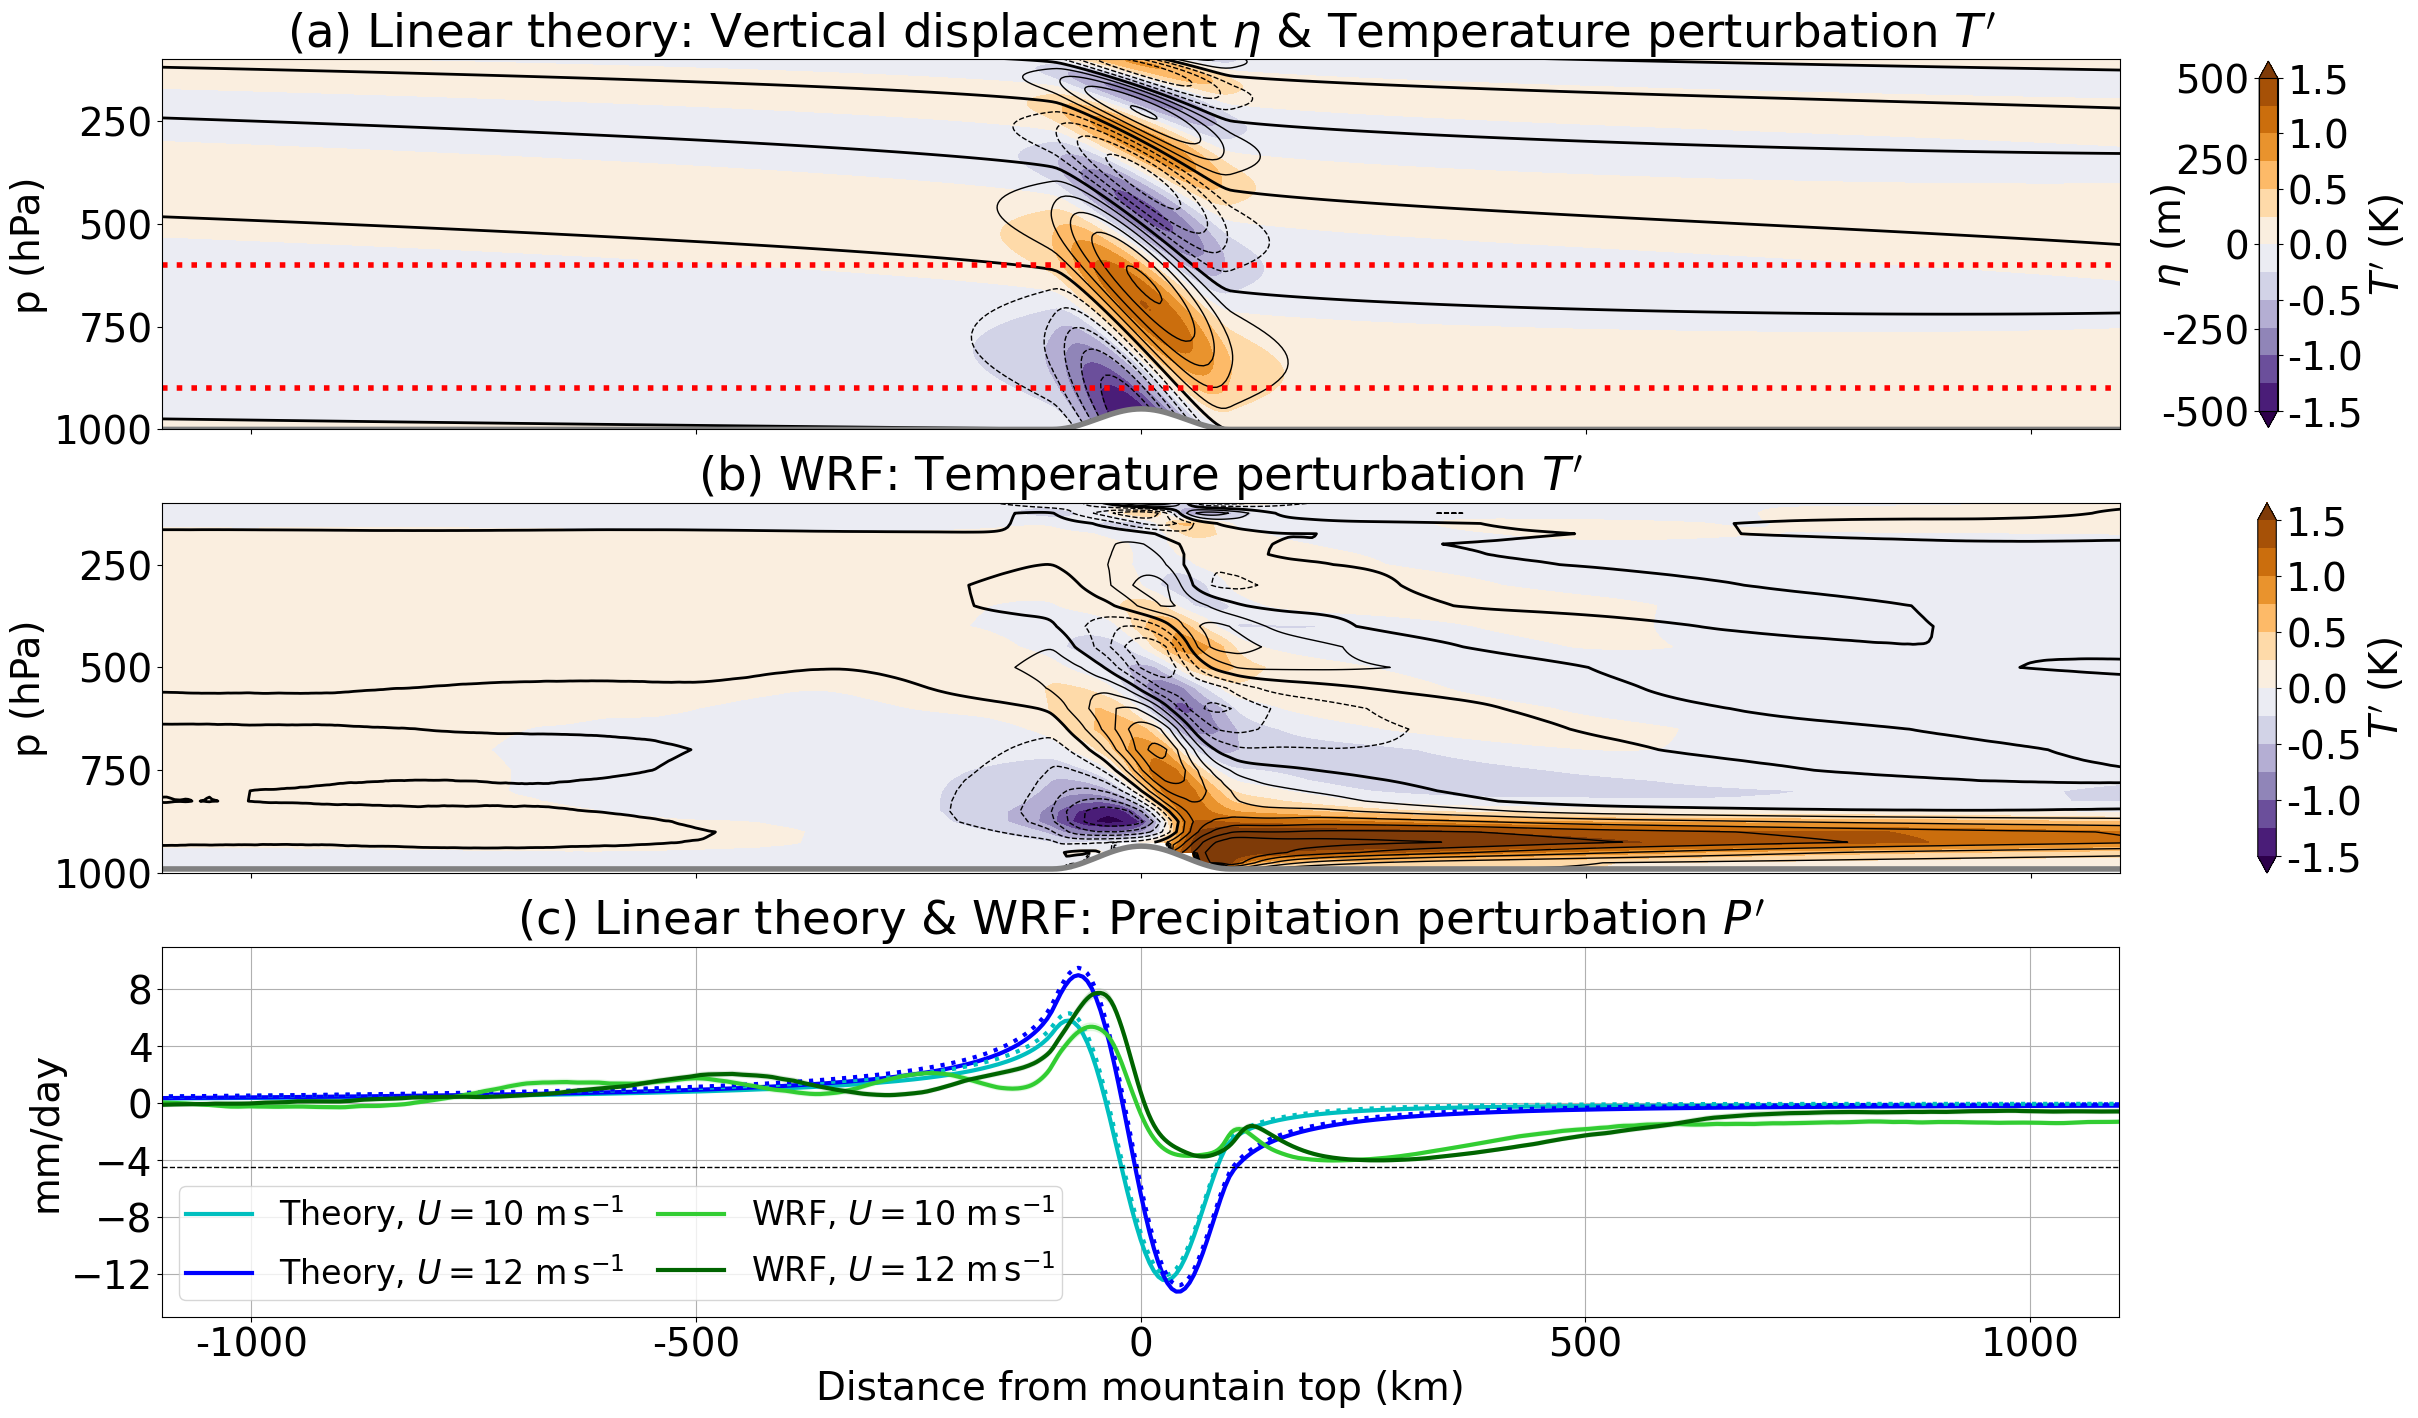

In [239]:
matplotlib.rcParams.update({'font.size': 28})
fig,(ax,axw,ax2,)=plt.subplots(3,1,figsize=(24,14),height_ratios=(1,1,1))


#### FIRST PLOT - eta in linear theory####
levs = np.arange(-1.5,1.6,0.25)
cbticks = np.arange(-500,501,250) # eta valeus
T_ticks = np.arange(-1.5,1.6,0.5)  # T' values
n=len(levs)

ds0dz = (300.*0.01**2/9.81)
im = (-ds0dz*zeta_10).swap_dims(z='p').plot.contourf(ax=ax, y='p',levels=levs,cmap = plt.cm.PuOr_r,extend='both',add_colorbar=False)
(-ds0dz*zeta_12).swap_dims(z='p').plot.contour (ax=ax, y='p',levels=levs,colors=['k']*n,linestyles=['--']*(n//2)+['-']*(n//2+1),linewidths=[1]*(n//2) + [2.] + [1]*(n//2))

# Make the colorbar
colorbar = plt.colorbar(im,label='',pad=0.065,fraction=0.01,aspect=20,shrink=0.9)
# Add left ticks
colorbar.ax.minorticks_off()
colorbar.ax.set_yticks(cbticks*ds0dz)
colorbar.ax.set_yticklabels(cbticks)
#colorbar.ax.set_ylim(levs[-1],levs[0])
colorbar.ax.text(-6,0.4,r"$\eta$ (m)",transform=colorbar.ax.transAxes,rotation='vertical')
# Add right ticks
secondary_axis = colorbar.ax.twinx()
secondary_axis.set_yticks(T_ticks)
secondary_axis.set_yticklabels(T_ticks)
secondary_axis.set_ylabel(r"$T'$ (K)")

# fill white space
xplot=zeta_10.x
ax.fill_between(xplot,1000*xplot**0,1000*xplot**0 - hx*0.1,color='w',zorder=2)
ax.plot(xplot,1000-hx/10,color='gray',linewidth=4)

ax.axhline(900.,color='r',linestyle=':',linewidth=4)
ax.axhline(600.,color='r',linestyle=':',linewidth=4)



#### SECOND PLOT - T' in WRF####
im = prime(W10S300.T_PL_MEAN).plot.contourf(ax=axw,y='pressure',yincrease=False,levels=levs,cmap=plt.cm.PuOr_r,extend='both',add_colorbar=False)
prime(W12S300.T_PL_MEAN).plot.contour (ax=axw,y='pressure',yincrease=False,levels=levs,colors='k',linestyles=['--']*(n//2)+['-']*(n//2+1),linewidths=[1]*(n//2) + [2.] + [1]*(n//2))
colorbar = plt.colorbar(im,label=r"$T'$ (K)",pad=0.065,fraction=0.01,aspect=20,ticks=T_ticks)
colorbar.ax.minorticks_off()
colorbar.ax.set_yticks(T_ticks)
colorbar.ax.set_yticklabels(T_ticks)
# fill white space
axw.fill_between(xplot,990*xplot**0,990 - hx/9,color='w',zorder=2)
axw.plot(xplot,990 - hx/9,color='gray',linewidth=4)

#### THIRD PLOT - precip in linear theory ####

ax2.plot(xplot,Pp_10,color='c',linewidth=3,label=r"Theory, $U=$10 m$\,$s$^{-1}$")
ax2.plot(xplot,Pp_12,color='b',linewidth=3,label=r"Theory, $U=$12 m$\,$s$^{-1}$")
ax2.plot(xplot,Pd_10,color='c',linewidth=3,linestyle=':')
ax2.plot(xplot,Pd_12,color='b',linewidth=3,linestyle=':')

#### FOURTH PLOT - precip in WRF ####
for Sim in (W10S300,W12S300):
    prime(Sim.RAINNC_MEAN).plot(ax=ax2,color=Sim.color2,label='WRF, '+Sim.label,linewidth=3,linestyle='-')
    #axw2.fill_between(Sim.RAINNC_MEAN.distance_from_mtn,prime(Sim.RAINNC_MEAN)-Sim.RAINNC_STERR,prime(Sim.RAINNC_MEAN)+Sim.RAINNC_STERR,alpha=0.1,color=Sim.color)
    ax2.fill_between(Sim.RAINNC_MEAN.distance_from_mtn,prime(Sim.RAINNC_MEAN)-Sim.RAINNC_STERR,prime(Sim.RAINNC_MEAN)+Sim.RAINNC_STERR,alpha=0.1,color=Sim.color2)


#### COMMON settings ####
for a in ax2,:
    divider2 = make_axes_locatable(a)
    cax2 = divider2.append_axes("right", size=1., pad=.6,axes_class=plt.Axes)
    cax2.remove()
    a.grid()
    a.legend(loc=3,borderpad=0.2,fontsize=24,ncol=2,columnspacing=1.)
    a.set_ylabel("mm/day")

ax2.set_ylim(-15,11)
ax2.set_yticks(np.arange(-12,9,4))
    
for a in ax,axw:
    a.set_ylim(1000.,100)
    a.set_ylabel('p (hPa)')
    
ticks = np.arange(-1000,1100,500)
for a in ax,axw,ax2,:
    a.set_xlim(-1100,1100)
    a.set_xticks(ticks)
    a.set_xticklabels('')
    a.set_xlabel('')
ax2.set_xticklabels(ticks)
ax2.set_xlabel('Distance from mountain top (km)')
ax2.axhline(-4.5,color='k',linestyle='--',linewidth=1.)


ax.set_title(r"(a) Linear theory: Vertical displacement $\eta$ & Temperature perturbation $T'$")
axw.set_title(r"(b) WRF: Temperature perturbation $T'$")
ax2.set_title(r"(c) Linear theory & WRF: Precipitation perturbation $P'$")
fig.tight_layout(pad=0.02)

## Further analyses

In [90]:
(prime(W12S300.RAINNC_MEAN).max() / prime(W10S300.RAINNC_MEAN).max() - 1).data*100/2

22.135378364363245

In [190]:
idx10 = prime(W10S300.RAINNC_MEAN).argmax().data
idx12 = prime(W12S300.RAINNC_MEAN).argmax().data
ts1 = (W10S300.RAINNC_DAILY.isel(distance_from_mtn = idx10) - upstream_mean(W10S300.RAINNC_MEAN)).load().data
ts2 = (W12S300.RAINNC_DAILY.isel(distance_from_mtn = idx12) - upstream_mean(W12S300.RAINNC_MEAN)).load().data

In [ ]:
def generate_sample(raints,blocksize = 1,nbootstrap = 10000):
    Nt = len(raints)
    nsamples_per_bootstrap = Nt//blocksize
    nsamples = nbootstrap*nsamples_per_bootstrap
    
    idxs = np.random.choice(Nt-blocksize,nsamples,replace=True)
    idx_blocks = np.broadcast_to(idxs,(blocksize,nsamples)).T + np.arange(blocksize)
    bootstrap_samples = raints[idx_blocks].reshape(nbootstrap,nsamples_per_bootstrap*blocksize)
    return bootstrap_samples

In [191]:
blocksize=20
bootstrap_estimates = generate_sample(ts2,blocksize,nbootstrap=50000).mean(axis=1)/generate_sample(ts1,blocksize,nbootstrap=50000).mean(axis=1)
(np.quantile(bootstrap_estimates,[0.025,0.975])-1)/2*100

array([17.87455335, 26.92369118])

In [192]:
blocksize=120
bootstrap_estimates2 = generate_sample(ts2,blocksize,nbootstrap=50000).mean(axis=1)/generate_sample(ts1,blocksize,nbootstrap=50000).mean(axis=1)
(np.quantile(bootstrap_estimates2,[0.025,0.975])-1)/2*100

array([16.87097281, 30.31454086])

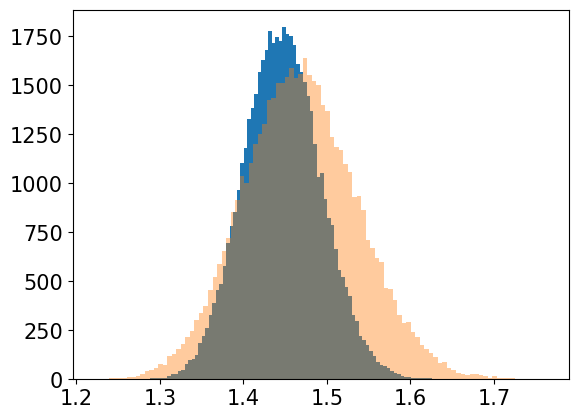

In [176]:
plt.hist(bootstrap_estimates,bins=100);
plt.hist(bootstrap_estimates2,bins=100,alpha=0.4);

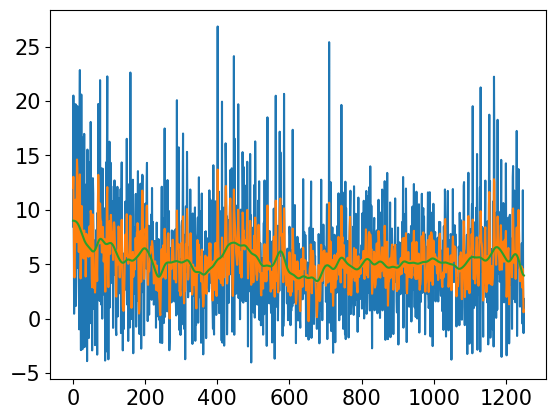

In [194]:
from scipy.ndimage import gaussian_filter
plt.plot(ts1)
plt.plot(gaussian_filter(ts1,1))
plt.plot(gaussian_filter(ts1,10))

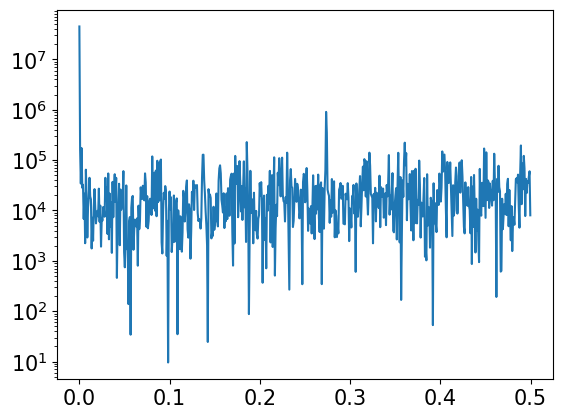

In [208]:
plt.plot(np.fft.rfftfreq(len(ts1),1),np.abs(np.fft.rfft(                ts1    ))**2)
#plt.plot(np.fft.rfftfreq(len(ts1),1),np.abs(np.fft.rfft(gaussian_filter(ts1,10)))**2)
plt.yscale('log')

## P' uncertainty estimates

In [151]:
blocksizes = [1,2,4,6,8,12,16,24,32]

In [126]:
raints = np.array(W10S300.RAINNC_DAILY.sel(distance_from_mtn = -2001))
bootstraps = np.array([generate_sample(raints,b).mean(axis=1) for b in blocksizes])

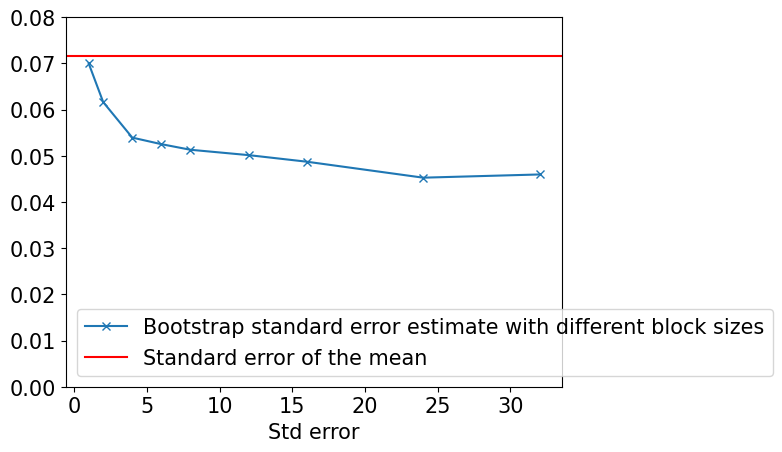

In [127]:
matplotlib.rcParams.update({'font.size': 15})
plt.plot(blocksizes,bootstraps.std(axis=1),'-x',label = 'Bootstrap standard error estimate with different block sizes')
plt.axhline(np.std(raints)/np.sqrt(Nt),label="Standard error of the mean",color='r')
plt.ylim(0.,0.08)
plt.xlabel('block size')
plt.xlabel('Std error')
plt.legend()

In [177]:
blocksizes = [1,2,4,6,8,12,16,24,32,64,100,128,150,180,220,256,512]

In [178]:
raints = np.array(W10S300.RAINNC_DAILY.sel(distance_from_mtn = -42))
bootstraps = np.array([generate_sample(raints,b).mean(axis=1) for b in blocksizes])

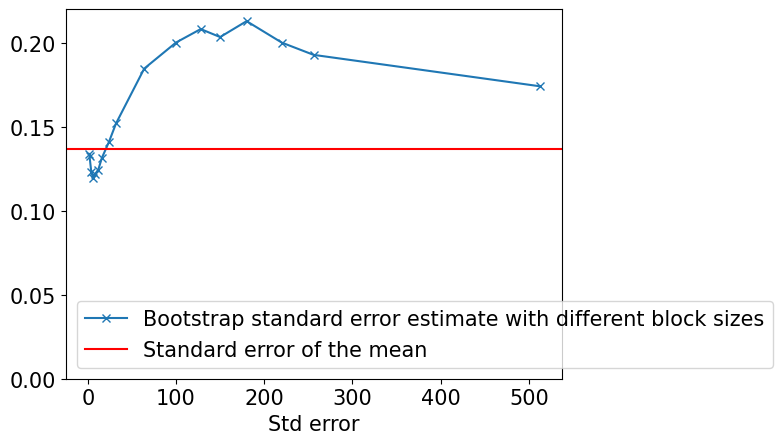

In [179]:
matplotlib.rcParams.update({'font.size': 15})
plt.plot(blocksizes,bootstraps.std(axis=1),'-x',label = 'Bootstrap standard error estimate with different block sizes')
plt.axhline(np.std(raints)/np.sqrt(Nt),label="Standard error of the mean",color='r')
plt.xlabel('block size')
plt.xlabel('Std error')
plt.ylim(0,0.22)
plt.legend()

In [180]:
raints = np.array(W10S300.RAINNC_DAILY.sel(distance_from_mtn = -60))
bootstraps = np.array([generate_sample(raints,b).mean(axis=1) for b in blocksizes])

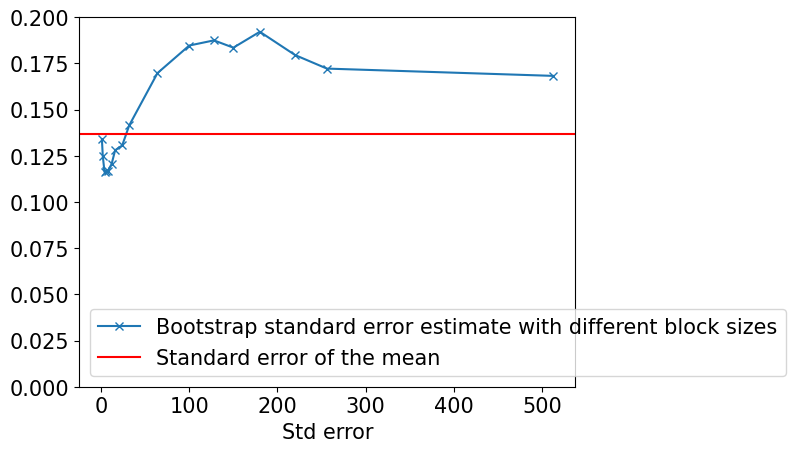

In [181]:
matplotlib.rcParams.update({'font.size': 15})
plt.plot(blocksizes,bootstraps.std(axis=1),'-x',label = 'Bootstrap standard error estimate with different block sizes')
plt.axhline(np.std(raints)/np.sqrt(Nt),label="Standard error of the mean",color='r')
plt.ylim(0,0.2)
plt.xlabel('block size')
plt.xlabel('Std error')
plt.legend()

# Simulations - B_L stuff

In [197]:
def smooth(ds):
    return xr.apply_ufunc(gaussian_filter,ds,kwargs={"sigma":2.})

class SymHandler(HandlerLine2D):
    def create_artists(self, legend, orig_handle,xdescent, ydescent, width, height, fontsize, trans):
        xx= 0.6*height
        return super(SymHandler, self).create_artists(legend, orig_handle,xdescent, xx, width, height, fontsize, trans)

In [200]:
from scipy.signal import hilbert
from scipy.integrate import cumtrapz
import scipy.linalg as spl
from orographicPrecipitation.observationsAndERA5.linearWaveModels import z_to_p_standard

def nonlinear_mountain_wave(x,h,z,U,N):
    z2=np.array(z).transpose()[::-1]
    f_L = -np.imag(hilbert(h))
    l=N/U
    H = h+1.j*f_L
    niter=20
    for i in range(niter):
        H = -1j*np.exp(-1j*l*h)*(np.imag(hilbert(np.real(H*np.exp(1j*l*h))))+1j*np.imag(hilbert(np.imag(H*np.exp(1j*l*h)))))
    f=np.imag(H)
    delta = h[:,None]*np.cos(l*(z[None,:]-h[:,None]))+f[:,None]*np.sin(l*(z[None,:]-h[:,None]))
    w=U*np.gradient(delta,x,axis=0)
    # displacement: xr.DataArray(z[None,:]-delta,coords={'x':x,'z':z},dims={'x':x,'z':z})
    return xr.DataArray(w,coords={'distance_from_mtn':x/1000,'altitude':z/1000},dims=['distance_from_mtn','altitude'])

z=np.linspace(0,20e3,200)
xx ,hx = orog.topographic_profile('cos',A=500)
xx = xx[1000:3001]
hx = hx[1000:3001]

w_nonlinear_10=nonlinear_mountain_wave(xx,hx,z,10.,1e-2)
w_nonlinear_12=nonlinear_mountain_wave(xx,hx,z,12.,1e-2)
p = z_to_p_standard(w_nonlinear_10.altitude*1000)
w_nonlinear_10 = w_nonlinear_10.assign_coords({'pressure':p}).swap_dims({'altitude':'pressure'})
w_nonlinear_12 = w_nonlinear_12.assign_coords({'pressure':p}).swap_dims({'altitude':'pressure'})

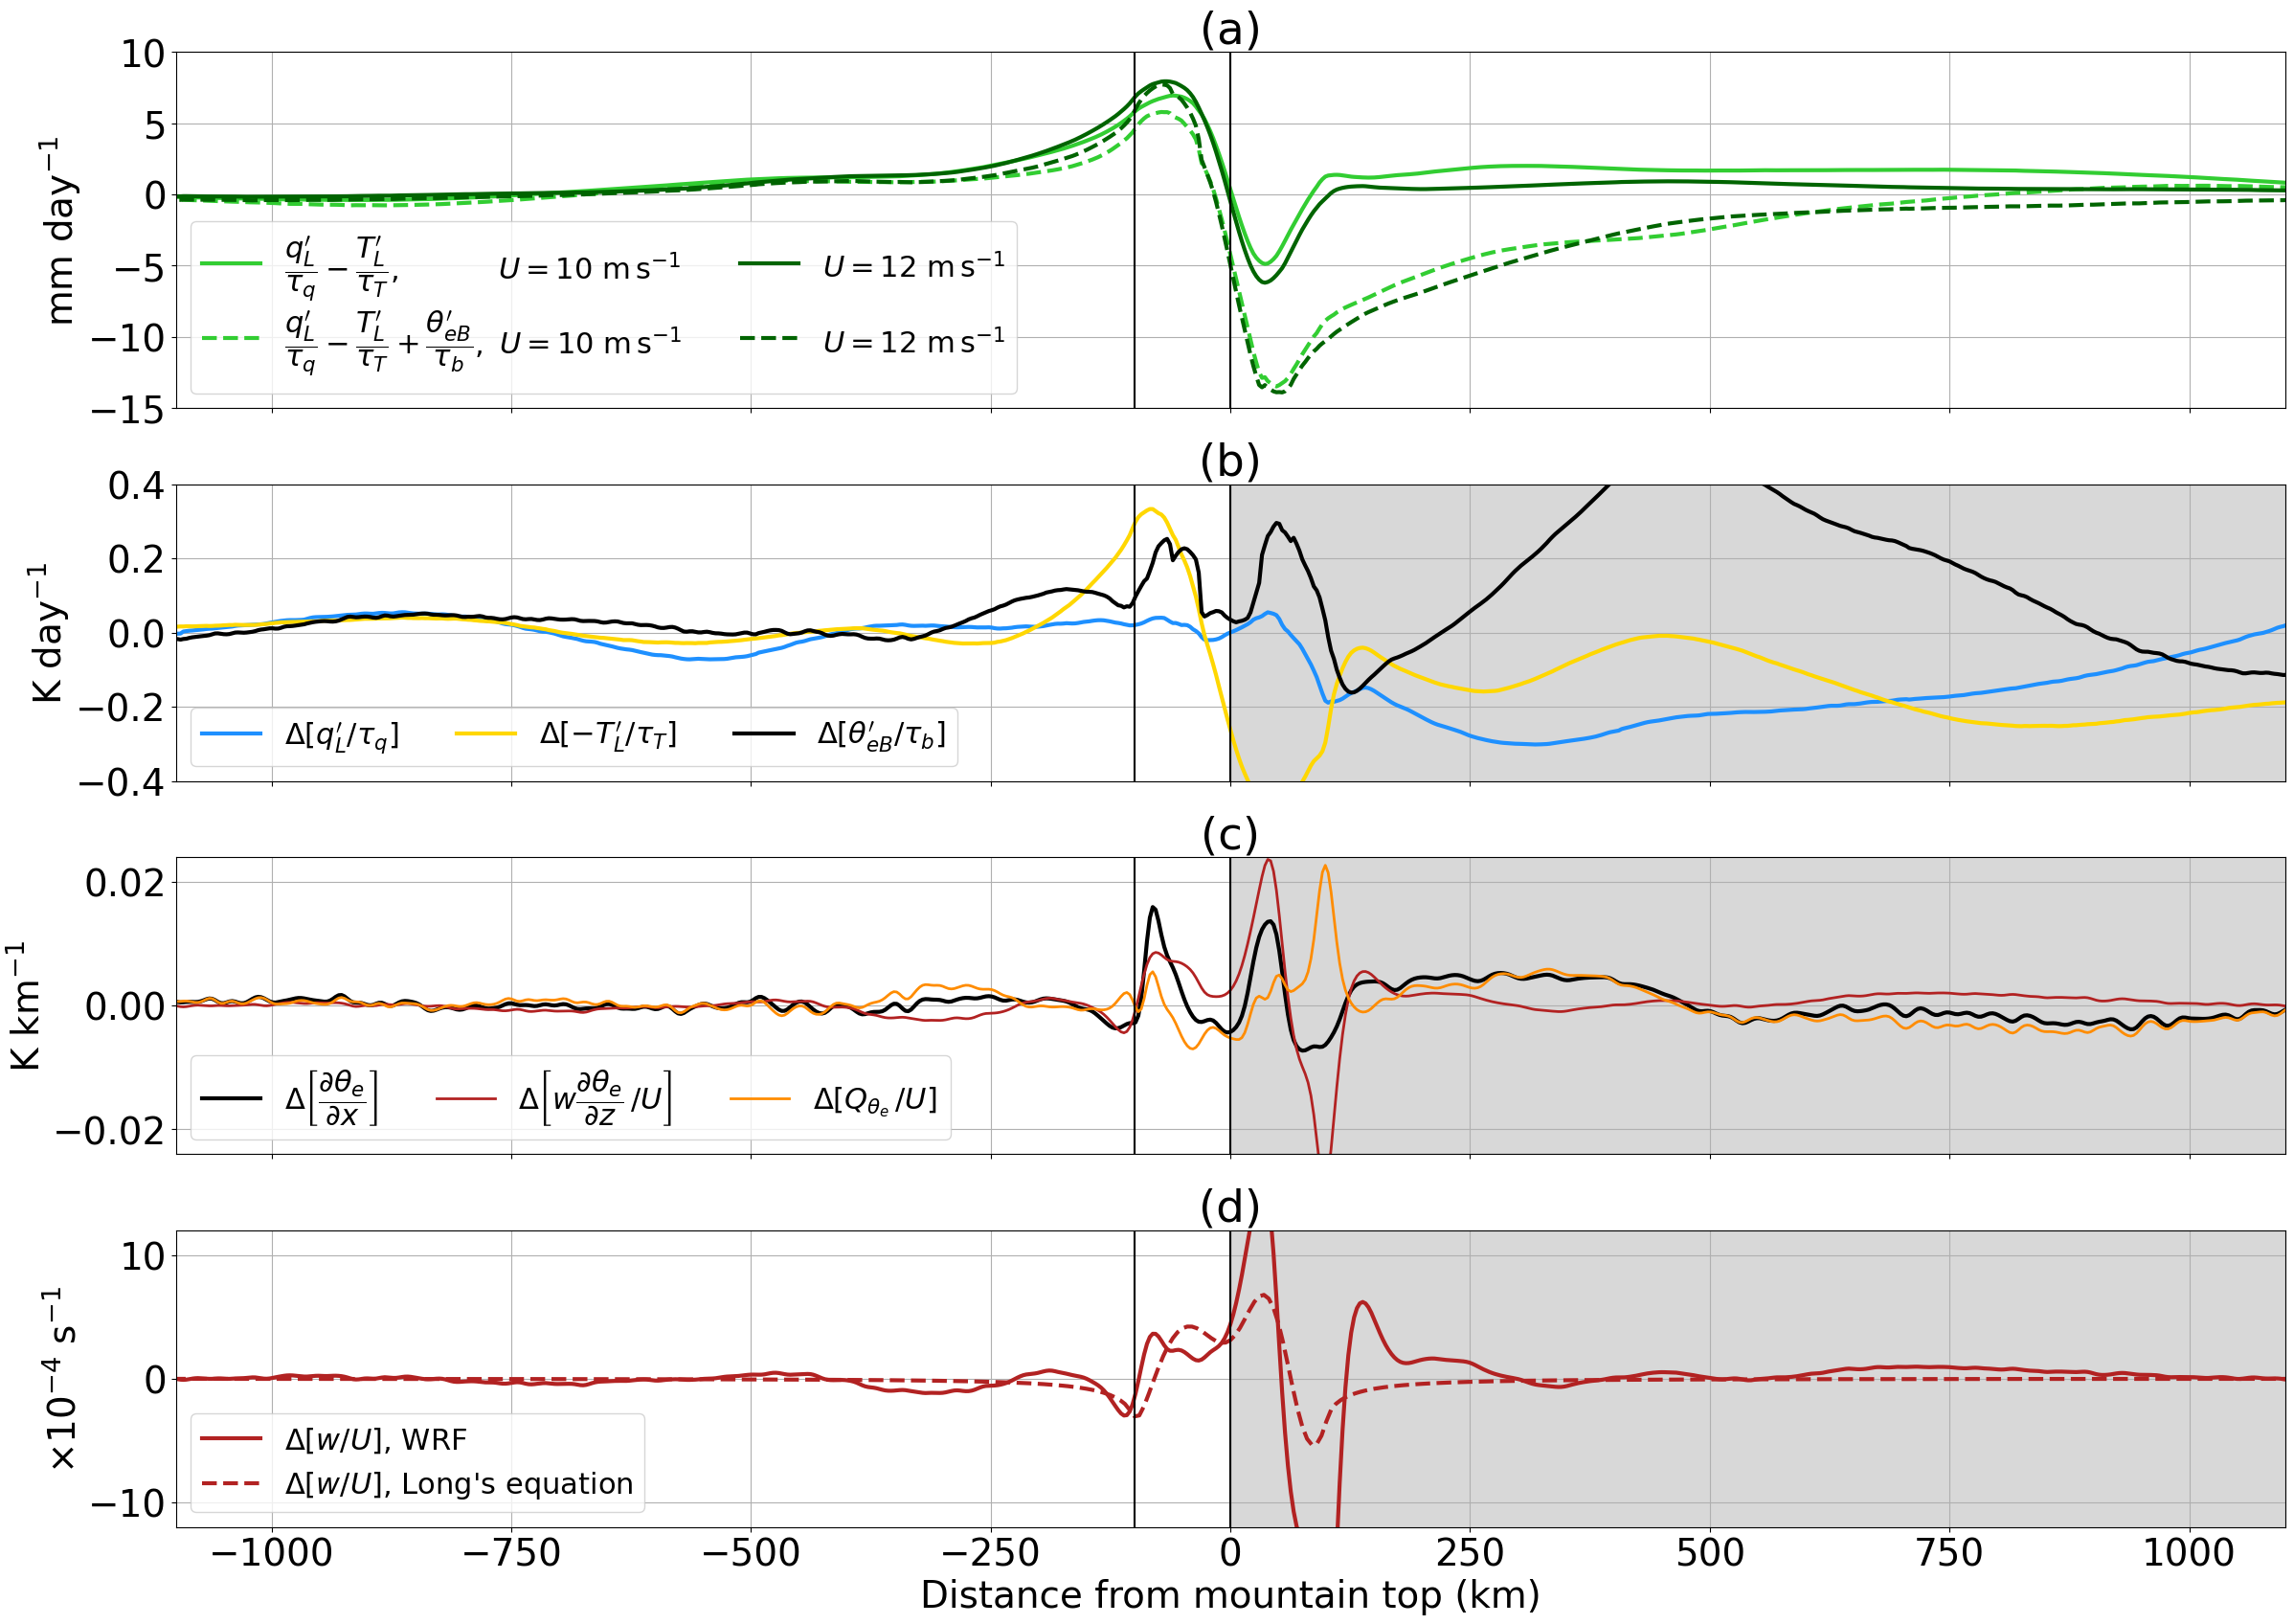

In [242]:
matplotlib.rcParams.update({'font.size': 28})
fig,axs=plt.subplots(4,1,figsize=(24,17),height_ratios = [1.2,1.,1.,1.])

legend_ftz=22
############################
######## FIRST PLOT ########
############################
ax = axs[0]
for i,Sim in enumerate((W10S300, W12S300)):
    TL = averageL(Sim.T_PL_MEAN,900,600)
    qL = averageL(Sim.Q_PL_MEAN,900,600)
    qL = qL * 2.5e6/1004.
    
    eB = averageB(Sim.THETAE_MEAN,Sim.PSFC_MEAN/100,900)
    
    conversion = 1004./2.5e6 * 8000 * 86400
    if i==0:
        lbl1 = r"$\dfrac{q_L'}{\tau_q}-\dfrac{T_L'}{\tau_T},$          " + Sim.label
        lbl2 = r"$\dfrac{q_L'}{\tau_q}-\dfrac{T_L'}{\tau_T}+\dfrac{\theta_{eB}'}{\tau_b},$ " + Sim.label
    else:
        lbl1 = Sim.label
        lbl2 = Sim.label
    (conversion * (- prime(TL) / 7.5 + prime(qL)/27.5               )   / 3600).plot(ax=ax,linestyle='-' ,color = Sim.color2,linewidth=3, label=lbl1)#Sim.color3
    (conversion * (- prime(TL) / 7.5 + prime(qL)/27.5 + prime(eB)/27.5) / 3600).plot(ax=ax,linestyle='--',color = Sim.color2,linewidth=3, label=lbl2)#Sim.color2
    

ax.set_ylim(-15,10)
ax.set_yticks(range(-15,11,5));
ax.legend(handler_map={matplotlib.lines.Line2D: SymHandler()}, 
          fontsize=legend_ftz, ncol=2,handleheight=3.5, labelspacing=0.05,loc=3,borderpad=0.4)

ax.set_ylabel(r'mm day$^{-1}$')

############################
######## SECOND PLOT ########
############################
ax = axs[1]
eB = averageB(Sim.THETAE_MEAN,Sim.PSFC_MEAN/100,900)
Deltaeb = (prime(averageB(W12S300.THETAE_MEAN,W12S300.PSFC_MEAN/100,900)) 
          -prime(averageB(W10S300.THETAE_MEAN,W10S300.PSFC_MEAN/100,900)))

Deltaeb2 = (prime(W12S300.THETAE_MEAN.sel(pressure=925))
           -prime(W10S300.THETAE_MEAN.sel(pressure=925)))

DeltaTL = (prime(averageL(W12S300.T_PL_MEAN,900,600)) 
          -prime(averageL(W10S300.T_PL_MEAN,900,600)))

DeltaqL = (prime(averageL(W12S300.Q_PL_MEAN,900,600)) 
          -prime(averageL(W10S300.Q_PL_MEAN,900,600)))* 2.5e6/1004.

Deltaeb = Deltaeb/(27.5/24)
DeltaTL = DeltaTL/(-7.5/24)
DeltaqL = DeltaqL/(27.5/24)

DeltaqL.plot(ax=ax,color = 'dodgerblue',linewidth=3, label=r"$\Delta[q_L'/\tau_q]$")
DeltaTL.plot(ax=ax,color = '#FFB000',linewidth=3, label=r"$\Delta[-T_L'/\tau_T]$")
Deltaeb.plot(ax=ax,color = 'k',linewidth=3, label=r"$\Delta[\theta_{eB}'/\tau_b]$")
#Deltaeb2.plot(ax=ax,color = 'k',linewidth=3,linestyle='--', label=r"$\Delta[\theta_{eB}']$")

ax.fill_between([0,1100],[-20.,-20.],[20.,20.],color='gray',alpha=0.3)
ax.set_ylim(-0.4,0.4)
ax.set_yticks(np.arange(-0.4,0.41,0.2));
ax.legend(fontsize=legend_ftz,loc=3,ncol=3)

ax.set_ylabel('K day$^{-1}$')

############################
####### THIRD PLOT ########
############################
ax=axs[2]
Delta0 = 1e3*(W12S300.THETAE_MEAN.sel(pressure=925).differentiate('distance_from_mtn')/1e3 
         -W10S300.THETAE_MEAN.sel(pressure=925).differentiate('distance_from_mtn')/1e3
         )
smooth(Delta0).plot(ax=ax,label = r"$\Delta \left[\dfrac{\partial \theta_e}{\partial x}\right]$",color='k',linewidth=3)

Delta1 = 1e3*((- W12S300.OMEGADTHETAEDP/86400)/12-(- W10S300.OMEGADTHETAEDP/86400)/10).sel(pressure=925)
smooth(Delta1).plot(ax=ax,color='firebrick',linewidth=2,label = r"$\Delta \left[w\dfrac{\partial \theta_e}{\partial z} \,/ U\right]$")

Delta2 = 1e3*((W12S300.QTHETAE/86400)/12-(W10S300.QTHETAE/86400)/10).sel(pressure=925)
smooth(Delta2).plot(ax=ax,color='darkorange',linewidth=2,label = r"$\Delta[ Q_{\theta_e} \,/ U]$ ")

ax.legend(fontsize=legend_ftz,loc=3,ncol=3)
ax.set_ylabel(r"K km$^{-1}$")
ax.fill_between([0,1100],[-1,-1],[1,1],color='gray',alpha=0.3)
ax.set_ylim(-24e-3,24e-3)

#ax2 = ax.twinx()
#(prime(W12S300.THETAE_MEAN.sel(pressure=925))-prime(W10S300.THETAE_MEAN.sel(pressure=925))).plot(ax=ax2,label = r"$\Delta[ \theta_e']$",color='k',linewidth=2,linestyle='--')
#ax2.legend(fontsize=legend_ftz,loc=4)
#ax2.set_ylabel(r"K")
#ax2.set_ylim(-1.1,1.1)


############################
######## FOURTH PLOT ########
############################
ax=axs[3]

smooth((1e4*(W12S300.W_PL_MEAN/12 - W10S300.W_PL_MEAN/10)).sel(pressure=925))    .plot(ax=ax,color='firebrick',linewidth=3,label=r"$\Delta[w/U]$, WRF")
(1e4*(w_nonlinear_12/12 - w_nonlinear_10/10)).sel(pressure=925.,method='nearest').plot(ax=ax,color='firebrick',linestyle='--',linewidth=3,label=r"$\Delta[w/U]$, Long's equation")

ax.legend(fontsize=legend_ftz,loc=3)
ax.fill_between([0,1100],[-20.,-20.],[20.,20.],color='gray',alpha=0.3)

ax.set_ylim(-12,12)
ax.set_ylabel(r"$\times 10^{-4}$ s$^{-1}$")

############################
###### FINAL TOUCHES #######
############################
for ax in axs:
    ax.set_title('')
    ax.set_xlim(-1100,1100)
    ax.grid()
    ax.axvline(-100.,color='k')
    ax.axvline(0.,color='k')
for ax in axs[:3]:
    ax.set_xlabel('')
    ax.set_xticklabels('')
axs[3].set_xlabel('Distance from mountain top (km)')
axs[0].set_title('(a)')
axs[1].set_title('(b)')
axs[2].set_title('(c)')
axs[3].set_title('(d)')
fig.tight_layout(pad=0.3)

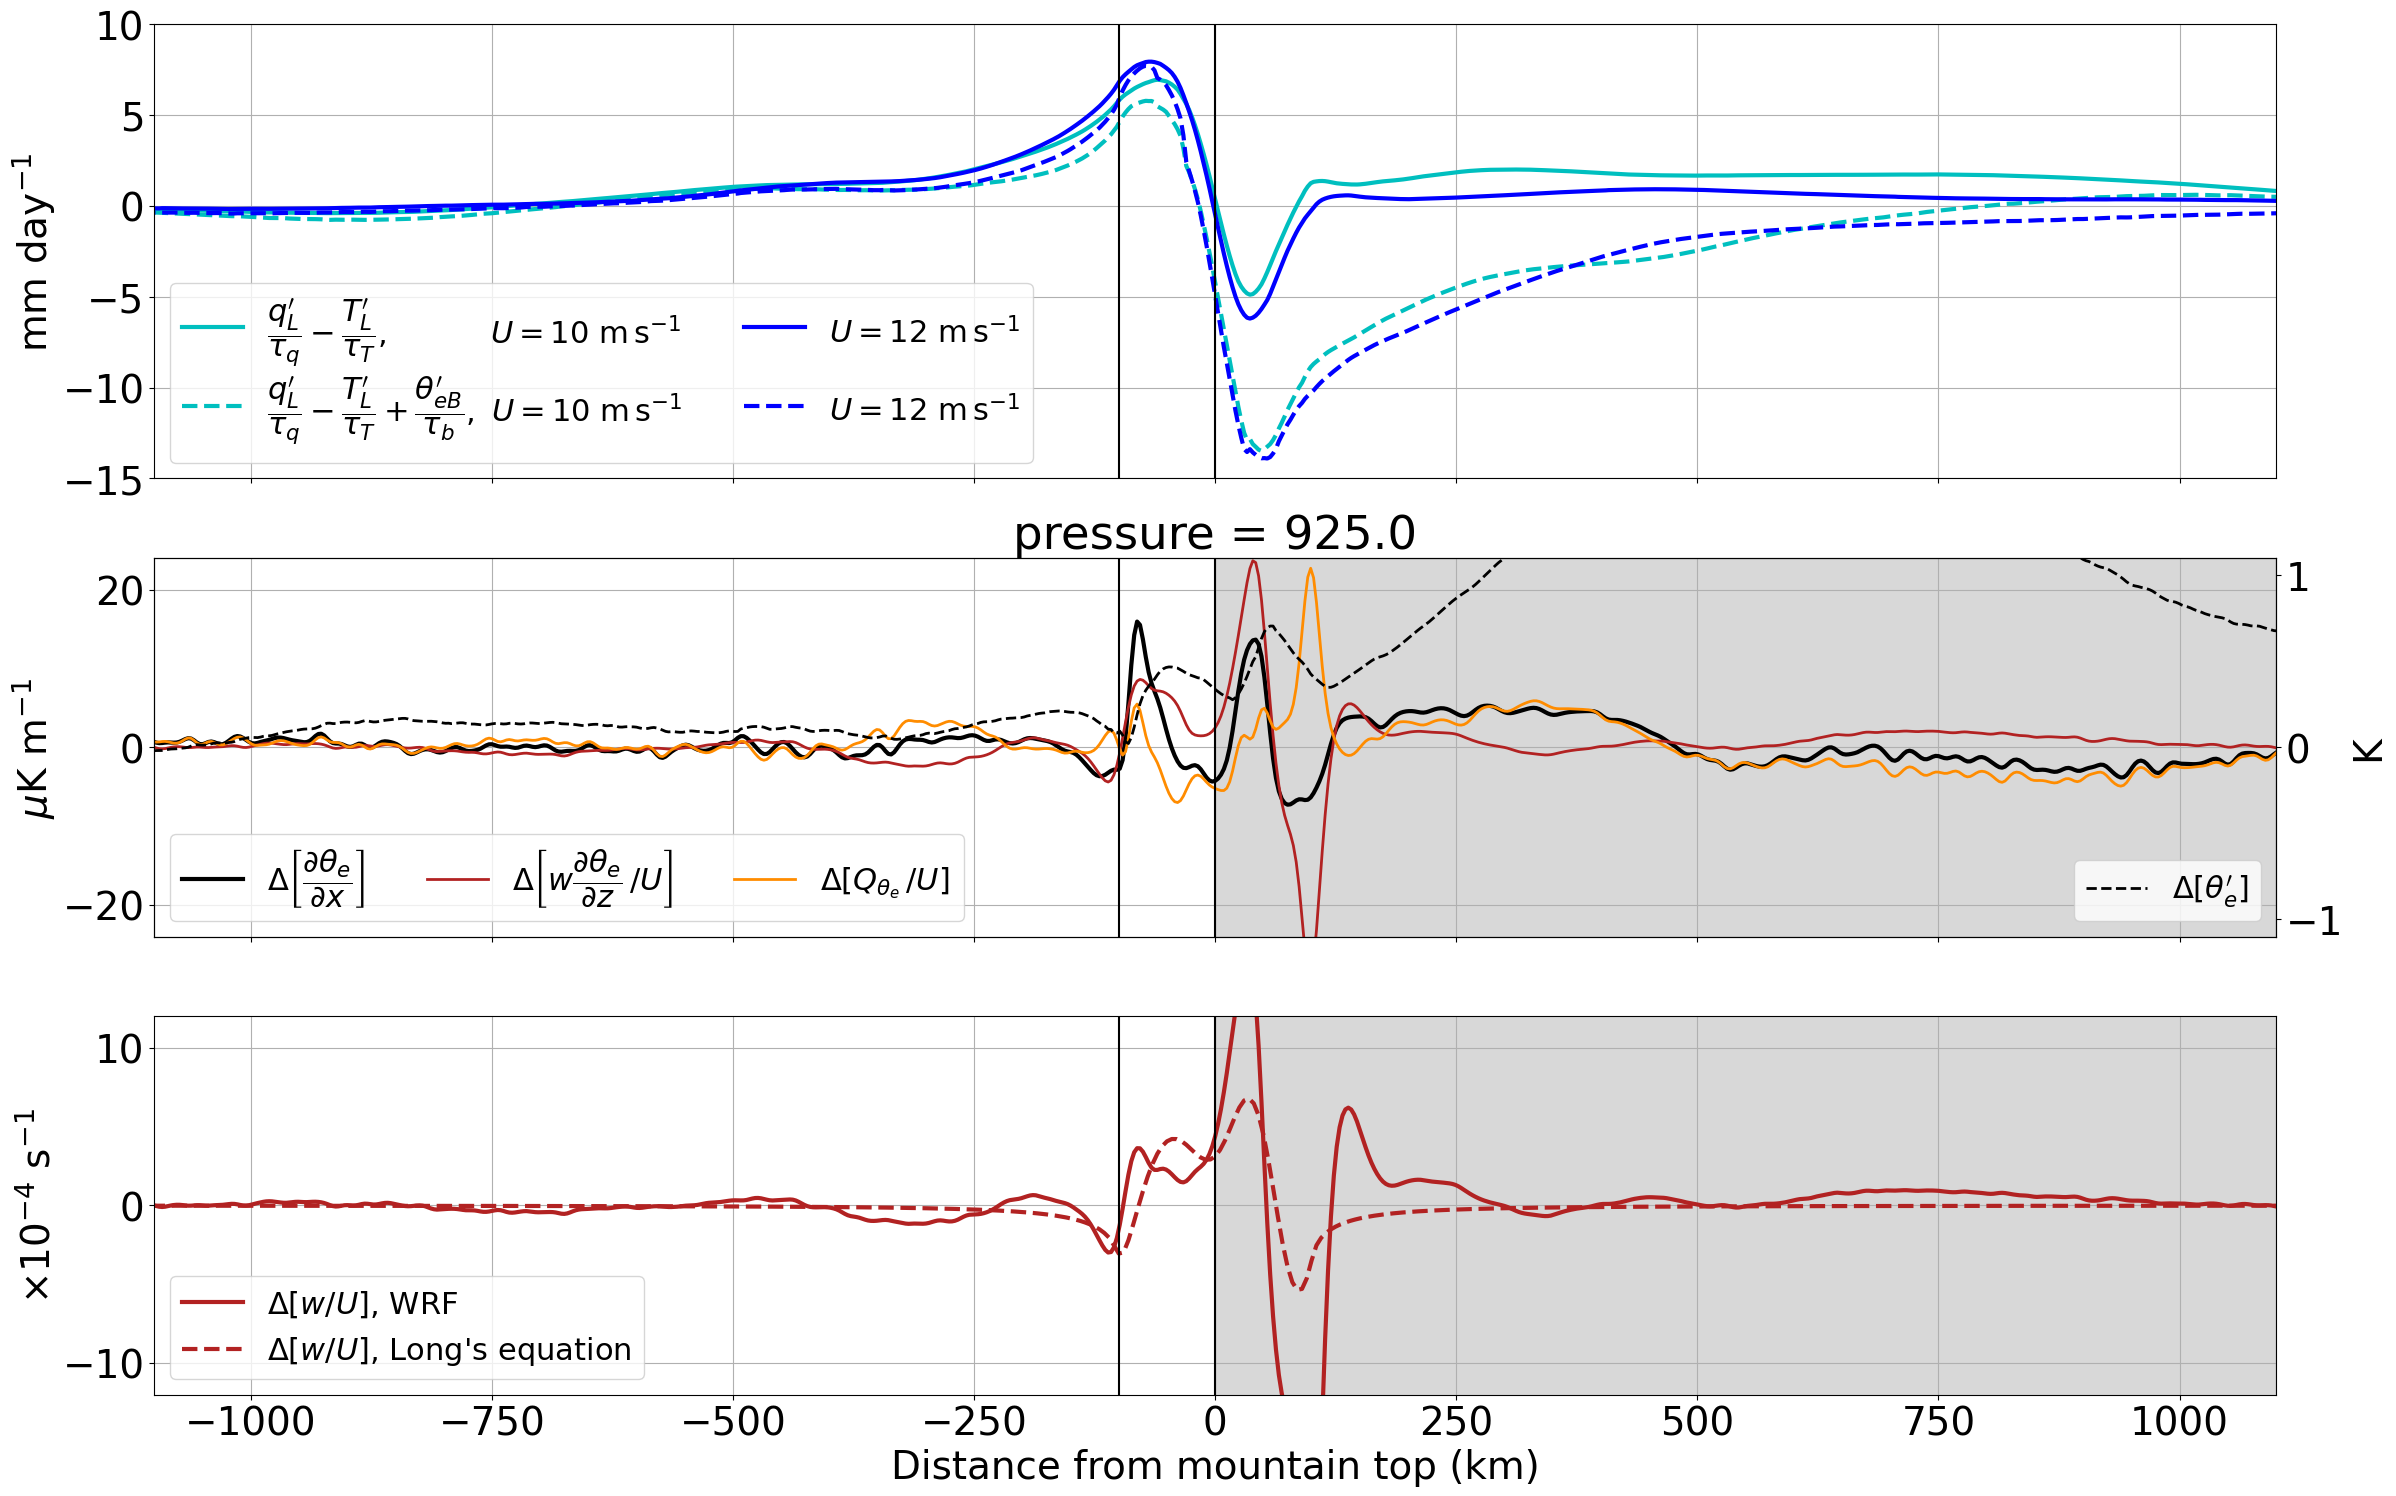

In [20]:
matplotlib.rcParams.update({'font.size': 28})
fig,axs=plt.subplots(3,1,figsize=(24,15),height_ratios = [1.2,1.,1.])

legend_ftz=22
############################
######## FIRST PLOT ########
############################
ax = axs[0]
for i,Sim in enumerate((W10S300, W12S300)):
    TL = averageL(Sim.T_PL_MEAN,900,600)
    qL = averageL(Sim.Q_PL_MEAN,900,600)
    qL = qL * 2.5e6/1004.
    
    eB = averageB(Sim.THETAE_MEAN,Sim.PSFC_MEAN/100,900)
    
    conversion = 1004./2.5e6 * 8000 * 86400
    if i==0:
        lbl1 = r"$\dfrac{q_L'}{\tau_q}-\dfrac{T_L'}{\tau_T},$          " + Sim.label
        lbl2 = r"$\dfrac{q_L'}{\tau_q}-\dfrac{T_L'}{\tau_T}+\dfrac{\theta_{eB}'}{\tau_b},$ " + Sim.label
    else:
        lbl1 = Sim.label
        lbl2 = Sim.label
    (conversion * (- prime(TL) / 7.5 + prime(qL)/27.5               )   / 3600).plot(ax=ax,linestyle='-' ,color = Sim.color,linewidth=3, label=lbl1)#Sim.color3
    (conversion * (- prime(TL) / 7.5 + prime(qL)/27.5 + prime(eB)/27.5) / 3600).plot(ax=ax,linestyle='--',color = Sim.color,linewidth=3, label=lbl2)#Sim.color2
    

ax.set_ylim(-15,10)
ax.set_yticks(range(-15,11,5));
ax.legend(handler_map={matplotlib.lines.Line2D: SymHandler()}, 
          fontsize=legend_ftz, ncol=2,handleheight=3.5, labelspacing=0.05,loc=3,borderpad=0.4)

ax.set_ylabel(r'mm day$^{-1}$')

############################
####### SECOND PLOT ########
############################
ax=axs[1]
Delta0 = 1e6*(W12S300.THETAE_MEAN.sel(pressure=925).differentiate('distance_from_mtn')/1e3 
         -W10S300.THETAE_MEAN.sel(pressure=925).differentiate('distance_from_mtn')/1e3
         )
smooth(Delta0).plot(ax=ax,label = r"$\Delta \left[\dfrac{\partial \theta_e}{\partial x}\right]$",color='k',linewidth=3)

Delta1 = 1e6*((- W12S300.OMEGADTHETAEDP/86400)/12-(- W10S300.OMEGADTHETAEDP/86400)/10).sel(pressure=925)
smooth(Delta1).plot(ax=ax,color='firebrick',linewidth=2,label = r"$\Delta \left[w\dfrac{\partial \theta_e}{\partial z} \,/ U\right]$")

Delta2 = 1e6*((W12S300.QTHETAE/86400)/12-(W10S300.QTHETAE/86400)/10).sel(pressure=925)
smooth(Delta2).plot(ax=ax,color='darkorange',linewidth=2,label = r"$\Delta[ Q_{\theta_e} \,/ U]$ ")

ax.legend(fontsize=legend_ftz,loc=3,ncol=3)
ax.set_ylabel(r"$\mu$K m$^{-1}$")
ax.set_ylim(-24,24)
ax.fill_between([0,1100],[-24,-24],[24,24.],color='gray',alpha=0.3)

ax2 = ax.twinx()
(prime(W12S300.THETAE_MEAN.sel(pressure=925))-prime(W10S300.THETAE_MEAN.sel(pressure=925))).plot(ax=ax2,label = r"$\Delta[ \theta_e']$",color='k',linewidth=2,linestyle='--')
ax2.legend(fontsize=legend_ftz,loc=4)
ax2.set_ylabel(r"K")
ax2.set_ylim(-1.1,1.1)


############################
######## THIRD PLOT ########
############################
ax=axs[2]

smooth((1e4*(W12S300.W_PL_MEAN/12 - W10S300.W_PL_MEAN/10)).sel(pressure=925))    .plot(ax=ax,color='firebrick',linewidth=3,label=r"$\Delta[w/U]$, WRF")
(1e4*(w_nonlinear_12/12 - w_nonlinear_10/10)).sel(pressure=925.,method='nearest').plot(ax=ax,color='firebrick',linestyle='--',linewidth=3,label=r"$\Delta[w/U]$, Long's equation")

ax.legend(fontsize=legend_ftz,loc=3)
ax.fill_between([0,1100],[-20.,-20.],[20.,20.],color='gray',alpha=0.3)

ax.set_ylim(-12,12)
ax.set_ylabel(r"$\times 10^{-4}$ s$^{-1}$")

############################
###### FINAL TOUCHES #######
############################
for ax in axs:
    ax.set_title('')
    ax.set_xlim(-1100,1100)
    ax.grid()
    ax.axvline(-100.,color='k')
    ax.axvline(0.,color='k')
for ax in axs[:2]:
    ax.set_xlabel('')
    ax.set_xticklabels('')
axs[2].set_xlabel('Distance from mountain top (km)')
fig.tight_layout(pad=0.3)

In [243]:
measures = [[],[],[]]
for Sim in W10S300 , W12S300:
    TL = averageL(Sim.T_PL_MEAN,900,600)
    qL = averageL(Sim.Q_PL_MEAN,900,600)
    qL = qL * 2.5e6/1004.
    
    #eB = averageB(Sim.T_PL_MEAN,Sim.PSFC_MEAN/100,900) + 2.5e3 * averageB(Sim.Q_PL_MEAN,Sim.PSFC_MEAN/100,900)
    eB = averageB(Sim.THETAE_MEAN,Sim.PSFC_MEAN/100,900)
    
    measures[0].append(prime(Sim.RAINNC_MEAN))
    measures[1].append(- prime(TL) / 7.5 + prime(qL)/27.5 + prime(eB)/27.5)
    measures[2].append(- prime(TL) / 7.5 + prime(qL)/27.5 )

for i in range(len(measures)):
    change = (measures[i][1].max()/measures[i][0].max() - 1) *100/2
    print( "%.2f %%/(m/s)"%(change) )
    

22.14 %/(m/s)
16.67 %/(m/s)
7.16 %/(m/s)


In [261]:
((W12S300.RAINNC_MEAN.sel(distance_from_mtn=slice(-20,-90)).mean()-4.5)/(W10S300.RAINNC_MEAN.sel(distance_from_mtn=slice(-20,-90)).mean()-4.5)-1)*50


<xarray.DataArray 'RAINNC_MMDY' ()>
array(21.61289022)

## Aside: changes with warming

In [14]:
W10S296   = SimulationCustom2('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.296K.3km/',1635,3,'1970010100-1970090900',inp=True)

In [20]:
W10S296.color='paleturquoise'
W10S296.color2='wheat'
W10S296.color3='greenyellow'

W10S300.label=r'SST = 300K'
W10S296.label=r'SST = 296K'

In [16]:
Sim = W10S296
Sim.PSFC_MEAN = xr.open_zarr(Sim.path + "wrf.PSFC_INTERP.1h.%s.zarr"%Sim.suffix2).PSFC[-480:].mean(('Time','south_north')).load()
Sim.THETAE_MEAN = xr.open_dataarray(Sim.path + "wrf.THETAE.ALLMEAN.nc")

(-1100.0, 1100.0)

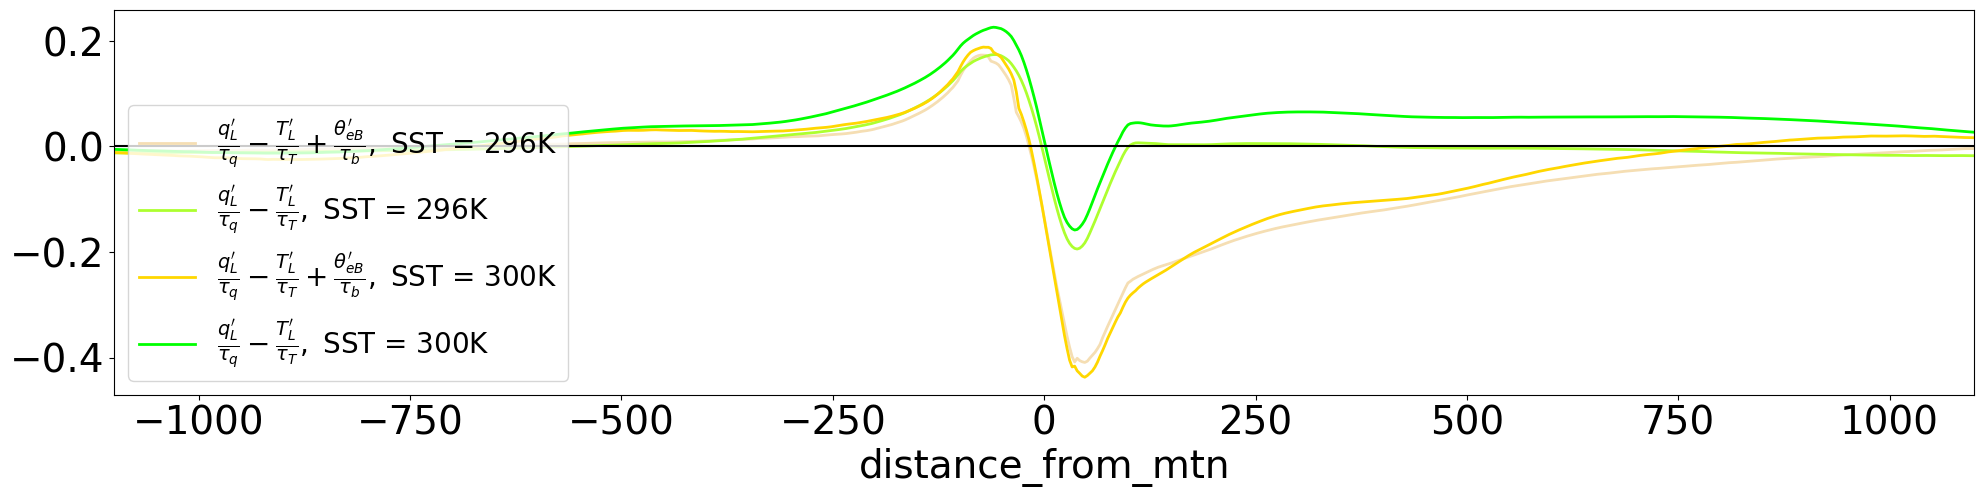

In [27]:
matplotlib.rcParams.update({'font.size': 28})
fig,ax=plt.subplots(1,1,figsize=(24,5))


for Sim in W10S296 , W10S300:
    TL = averageL(Sim.T_PL_MEAN,900,600)
    qL = averageL(Sim.Q_PL_MEAN,900,600)
    qL = qL * 2.5e3
    
    #eB = averageB(Sim.T_PL_MEAN,Sim.PSFC_MEAN/100,900) + 2.5e3 * averageB(Sim.Q_PL_MEAN,Sim.PSFC_MEAN/100,900)
    eB = averageB(Sim.THETAE_MEAN,Sim.PSFC_MEAN/100,900)
    
    (- prime(TL) / 3 + prime(qL)/11 + prime(eB)/11).plot(ax=ax,color = Sim.color2,linewidth=2, label=r"$\frac{q_L'}{\tau_q}-\frac{T_L'}{\tau_T}+\frac{\theta_{eB}'}{\tau_b},$ " + Sim.label)
    (- prime(TL) / 3 + prime(qL)/11               ).plot(ax=ax,color = Sim.color3,linewidth=2, label=r"$\frac{q_L'}{\tau_q}-\frac{T_L'}{\tau_T},$ " + Sim.label)
ax.axhline(0.,color='k')
ax.legend(fontsize=20,loc=3)
ax.set_xlim(-1100,1100)

Text(0.5, 1.0, "Precipitation perturbation $P'$")

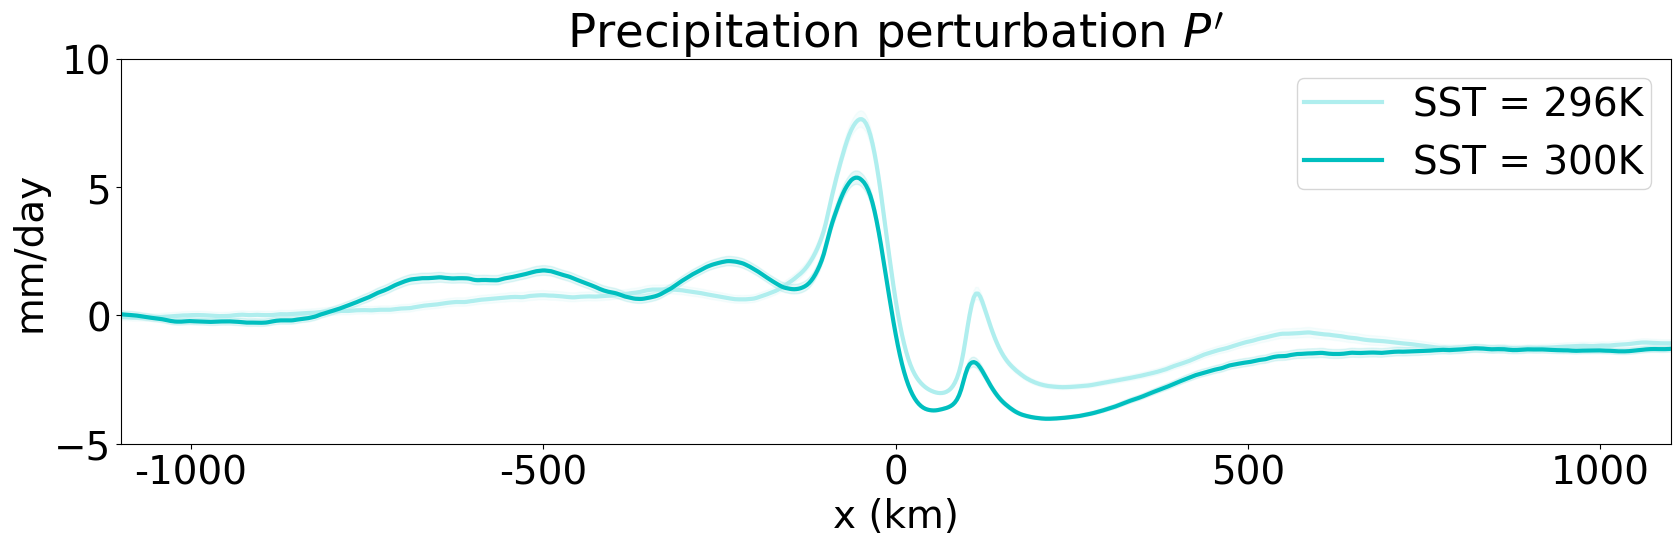

In [22]:
matplotlib.rcParams.update({'font.size': 28})
fig,ax2=plt.subplots(1,1,figsize=(20,5))


ticks = np.arange(-1000,1100,500)

for Sim in (W10S296,W10S300):
    prime(Sim.RAINNC_MEAN).plot(ax=ax2,color=Sim.color,label=Sim.label,linewidth=3)
    ax2.fill_between(Sim.RAINNC_MEAN.distance_from_mtn,prime(Sim.RAINNC_MEAN)-Sim.RAINNC_STERR,prime(Sim.RAINNC_MEAN)+Sim.RAINNC_STERR,alpha=0.1,color=Sim.color)

ax2.set_ylim(-5,10)
ax2.set_ylabel("mm/day")
ax2.set_xlim(-1100,1100)
ax2.set_xticks(list(ticks))
ax2.set_xticklabels(ticks)
ax2.set_xlabel('x (km)')

#yticks=np.arange(-40,41,20)
#ax2.set_yticks(yticks)
ax2.legend(loc=1,borderpad=0.2,fontsize=28)

ax2.set_title(r"Precipitation perturbation $P'$")



# Observations

In [55]:
add_wind?

Signature:
add_wind(
    ax,
    u,
    v,
    color='k',
    width=0.001,
    scale=600,
    key=True,
    ref=10,
    unit='m/s',
    pos=(0.87, 1.03),
    nm=5,
    fontproperties=None,
)
Docstring: <no docstring>
File:      /tmp/ipykernel_1278808/3251130127.py
Type:      function

In [64]:
def plot_regs(axs,MR,dataset,precip_mag=30,regmag=0.1,subtract_ups = False):
    ### DATA
    box_region = MR.box
    rect_region = MR.tilted_rect
    angle = MR.angle
    mask_region = gt.sel_box(dataset.region_masks[MR.name],box_region)
    
    u100 = e5_100u_seasonal_yearly[tuple(MR.months)]
    v100 = e5_100v_seasonal_yearly[tuple(MR.months)]
    precip = dataset.precip_seasonal_yearly[tuple(MR.months)]
    
    u100 = gt.sel_box(u100.sel(year=slice(1960,2015)),box_region)
    v100 = gt.sel_box(v100.sel(year=slice(1960,2015)),box_region)
    precip = gt.sel_box(precip.sel(year=slice(1960,2015)),box_region)
    crossslopeu = gt.crossslopeflow(u100,v100,angle)
    
    mask_wind = mu.tilted_rect(u100,*rect_region,True)
    mask_upstream = mu.tilted_rect_distance(precip,*rect_region[:-1],-2,-4)
    
    aspect=30; pad=0.04; shrink=0.8
    
    ### FIRST PLOT ###
    precip.mean('year').plot.contourf(ax=axs[0],
                                      transform=ccrs.PlateCarree(),
                                      levels=np.linspace(0,30,11),
                                      cmap=plt.cm.GnBu,
                                      cbar_kwargs={'label':r'mm day$^{-1}$','aspect':aspect,'pad':pad,'shrink':shrink}
                                     )
    add_wind(axs[0],u100.mean('year'),v100.mean('year'),width=0.003,scale=200,nm=7,color='k',ref=10,pos=(0.83, 1.03))
    
    ### SECOND PLOT ###
    wind_ts = gt.spatial_mean(crossslopeu,mask = mask_wind)
    precip_reg = gt.linregress_xr(wind_ts,precip,dim='year')
    fdrfact = gt.fdr_xr_2d(precip_reg.pvalue,0.1) * precip_reg.pvalue**0
    (100*precip_reg.slope/precip.mean('year')).plot.contourf(ax=axs[1],
                                                             transform=ccrs.PlateCarree(),
                                                             levels=np.linspace(-30,30,13),
                                                             extend='both',
                                                             cbar_kwargs={'aspect':aspect,'pad':pad,'shrink':shrink,
                                                                          'label':r"%$\,\left(\text{m}\,\text{s}^{-1}\right)^{-1}$"})
    
    hatches = fdrfact.plot.contourf(ax=axs[1], levels=[0.5,1], colors='none', hatches=['','//'], alpha=0,add_colorbar=False)
    
    ### DECORATION ###
    grid_hr = gt.sel_box(MR.vars['IMERG_DAILY'],MR.box)
    mask_wind_hr = mu.tilted_rect(grid_hr,*rect_region,True)
    mask_above_hr = lsm.interp_like(grid_hr) * mu.tilted_rect(grid_hr,*rect_region,False)
    mask_upstream_hr = mu.tilted_rect_distance(grid_hr,*rect_region[:-1],-2,-4)
    
    mask_wind_hr.plot.contour(ax=axs[0],transform=ccrs.PlateCarree(),levels=[0.5],colors='b',linestyles=['--']) 
    mask_above_hr.plot.contour(ax=axs[1],transform=ccrs.PlateCarree(),levels=[0.5],colors='k',linestyles=['--'],linewidths=[1.5])
    mask_upstream_hr.plot.contour(ax=axs[1],transform=ccrs.PlateCarree(),levels=[0.5],colors='k',linestyles=['-']) 
    for ax in axs:
        smooth(gt.sel_box(topo_hires,box_region)).plot.contour(ax=ax,levels=[500.],colors='#555555',linewidths=[1.])
        ax.coastlines(linewidth=2)
        ax.set_xlim(box_region[0],box_region[1])
        ax.set_ylim(box_region[2],box_region[3])
        add_latlon(ax,box_region)

In [13]:
def detrend_xr(da):
    # Calculate the linear trend
    trend = da.polyfit(dim='year', deg=1)
    
    # Extract the slope and intercept of the linear trend
    slope = trend.polyfit_coefficients[0]
    intercept = trend.polyfit_coefficients[1]
    
    # Create a time series of the trend
    trend_ts = slope * da.year + intercept
    
    # Detrend the original time series by subtracting the trend
    return da - trend_ts

In [14]:
def get_sensitivity(MR,dataset,option = 0,detrend=False):
    ### DATA
    box_region = MR.box
    rect_region = MR.tilted_rect
    angle = MR.angle
    mask_region = gt.sel_box(dataset.region_masks[MR.name],box_region)
    
    u100 = e5_100u_seasonal_yearly[tuple(MR.months)]
    v100 = e5_100v_seasonal_yearly[tuple(MR.months)]
    precip = dataset.precip_seasonal_yearly[tuple(MR.months)]
    
    u100 = gt.sel_box(u100.sel(year=slice(1960,2015)),box_region)
    v100 = gt.sel_box(v100.sel(year=slice(1960,2015)),box_region)
    precip = gt.sel_box(precip.sel(year=slice(1960,2015)),box_region)
    crossslopeu = gt.crossslopeflow(u100,v100,angle)
    
    mask_wind = mu.tilted_rect(u100,*rect_region,True)
    mask_upstream = mu.tilted_rect_distance(precip,*rect_region[:-1],-2,-4)
    
     ### Get sensitivity with bounds
    wind_ts = gt.spatial_mean(crossslopeu,mask = mask_wind)
    precip_ts = gt.spatial_mean(precip,mask = mask_region)
    if detrend:
        wind_ts = wind_ts.mean()+detrend_xr(wind_ts)
        precip_ts = precip_ts.mean()+detrend_xr(precip_ts)
    
    if option==0 or option == 1:
        slope0 = gt.linregress_xr(wind_ts,precip_ts,dim='year').slope
        joint_sample = gt.generate_joint_sample(np.vstack((wind_ts.data, precip_ts.data)),blocksize=1,nbootstrap=100000)
        wind_sample = xr.DataArray(joint_sample[0],dims = ['bootstrap','year'])
        precip_sample = xr.DataArray(joint_sample[1],dims = ['bootstrap','year'])
        slope_sample = gt.linregress_xr(wind_sample,precip_sample,dim='year').slope
        
        if option==0:
            sensitivity0 = 100* slope0 / precip_ts.mean('year')
            sensitivity_sample = 100* slope_sample / precip_sample.mean('year')
            print("P",end=' ')
        elif option==1:
            sensitivity0 = 100* slope0 / (precip_ts-MR.P0).mean('year')
            sensitivity_sample = 100* slope_sample / (precip_sample-MR.P0).mean('year')
            print("Using P0 = %i mm/day: P'"%MR.P0,end=' ')
    elif option==2:
        precip_ts_upstream = gt.spatial_mean(precip,mask = mask_upstream)
        if detrend:
            precip_ts_upstream = precip_ts_upstream.mean()+detrend_xr(precip_ts_upstream)
        slope0 = gt.linregress_xr(wind_ts,precip_ts-precip_ts_upstream,dim='year').slope
        sensitivity0 = 100* slope0 / (precip_ts-precip_ts_upstream).mean('year')
        
        joint_sample = gt.generate_joint_sample(np.vstack((wind_ts.data, precip_ts.data,precip_ts_upstream.data)),blocksize=1,nbootstrap=100000)
        wind_sample = xr.DataArray(joint_sample[0],dims = ['bootstrap','year'])
        pprime_sample = xr.DataArray(joint_sample[1]-joint_sample[2],dims = ['bootstrap','year'])
        slope_sample = gt.linregress_xr(wind_sample,pprime_sample,dim='year').slope
        sensitivity_sample = 100* slope_sample / pprime_sample.mean('year')
        print("Calculating P0 200-400km upstream: P'", end=' ')

    sens, upper, lower = (sensitivity0, np.quantile(sensitivity_sample,0.025),np.quantile(sensitivity_sample,0.975))
    print("sensitivity: %.1f [%.1f - %.1f] %% / (m/s)"%(sens, upper, lower))
    return sens, upper, lower

def get_sensitivity_daily(MR):
    ### DATA
    angle = MR.angle

    ### Get sensitivity with bounds
    wind_ts = gt.crossslopeflow(MR.vars['U100_DAILY_BOXWIND'],MR.vars['V100_DAILY_BOXWIND'],angle)
    precip_ts = MR.vars['IMERG_DAILY_ABOVE'] 
    precip_ts_upstream = MR.vars['IMERG_DAILY_UPSTREAM']

    slope0 = gt.linregress_xr(wind_ts,precip_ts-precip_ts_upstream,dim='time').slope
    sensitivity0 = 100* slope0 / (precip_ts-precip_ts_upstream).mean('time')
    
    joint_sample = gt.generate_joint_sample(np.vstack((wind_ts.data, precip_ts.data,precip_ts_upstream.data)),blocksize=1,nbootstrap=10000)
    wind_sample = xr.DataArray(joint_sample[0],dims = ['bootstrap','time'])
    pprime_sample = xr.DataArray(joint_sample[1]-joint_sample[2],dims = ['bootstrap','time'])
    slope_sample = gt.linregress_xr(wind_sample,pprime_sample,dim='time').slope
    sensitivity_sample = 100* slope_sample / pprime_sample.mean('time')
    print("Calculating P0 200-400km upstream: P'", end=' ')

    sens, upper, lower = (sensitivity0, np.quantile(sensitivity_sample,0.025),np.quantile(sensitivity_sample,0.975))
    print("sensitivity: %.1f [%.1f - %.1f] %% / (m/s)"%(sens, upper, lower))
    return sens, upper, lower

In [17]:
sensitivities = np.zeros((len(MRs),3,3))
for i,MR in enumerate(MRs):
    for j,DS in enumerate([APHRODITE,ERA5]):
        option=(j==1) * 2
        sensitivities[i,j] = get_sensitivity(MR,DS,option=option)
    sensitivities[i,2] = get_sensitivity_daily(MR)

P sensitivity: 15.1 [4.6 - 21.2] % / (m/s)
Calculating P0 200-400km upstream: P' sensitivity: 25.4 [15.2 - 32.5] % / (m/s)
Calculating P0 200-400km upstream: P' sensitivity: 31.7 [29.0 - 34.7] % / (m/s)
P sensitivity: 14.5 [9.9 - 19.0] % / (m/s)
Calculating P0 200-400km upstream: P' sensitivity: 32.8 [21.7 - 46.7] % / (m/s)
Calculating P0 200-400km upstream: P' sensitivity: 34.1 [28.6 - 40.7] % / (m/s)
P sensitivity: 14.5 [5.4 - 24.9] % / (m/s)
Calculating P0 200-400km upstream: P' sensitivity: 30.9 [15.9 - 47.6] % / (m/s)
Calculating P0 200-400km upstream: P' sensitivity: 22.4 [14.1 - 33.4] % / (m/s)
P sensitivity: 4.1 [-5.4 - 12.7] % / (m/s)
Calculating P0 200-400km upstream: P' sensitivity: 26.0 [5.8 - 48.8] % / (m/s)
Calculating P0 200-400km upstream: P' sensitivity: 17.1 [11.0 - 23.7] % / (m/s)
P sensitivity: -1.8 [-8.1 - 4.0] % / (m/s)
Calculating P0 200-400km upstream: P' sensitivity: 20.9 [3.7 - 38.4] % / (m/s)
Calculating P0 200-400km upstream: P' sensitivity: 21.2 [18.0 - 24.

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


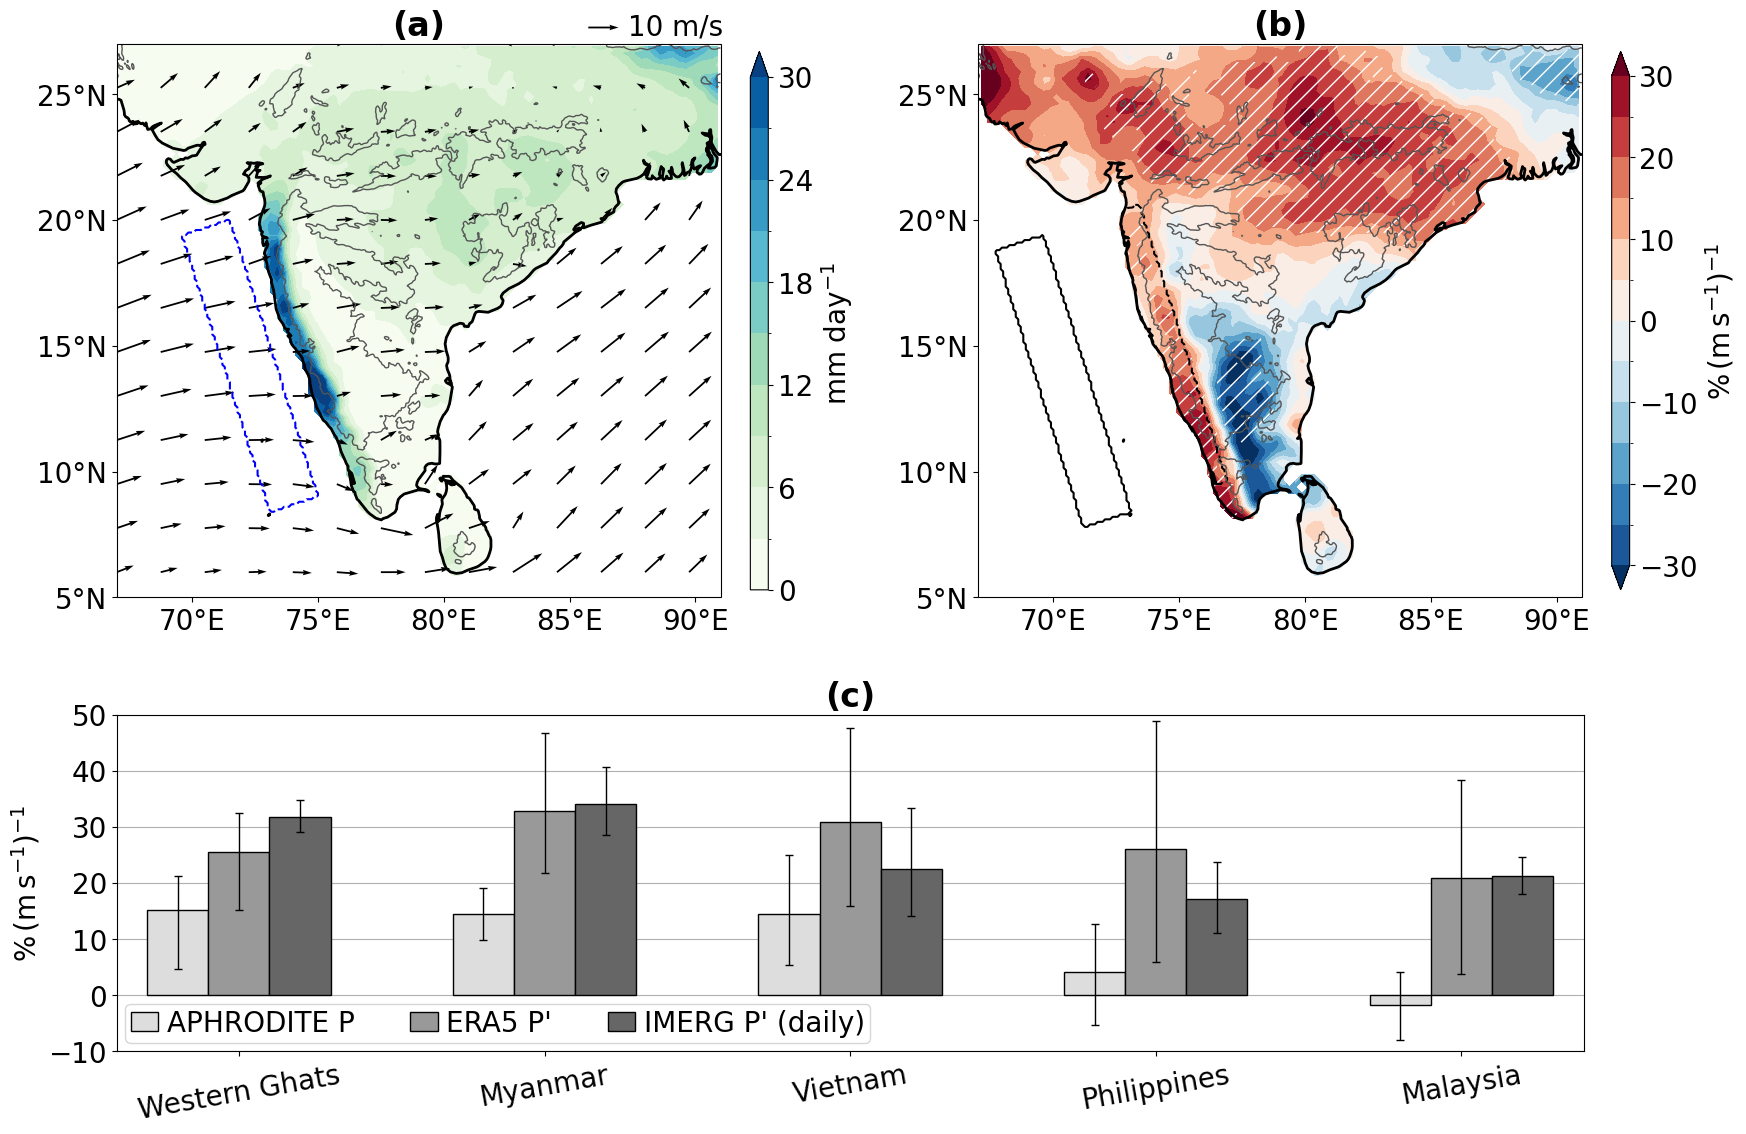

In [65]:
matplotlib.rcParams.update({'font.size':20})
plt.rcParams['hatch.color'] = 'w'

# Create a figure and a set of subplots
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[2, 1], figure=fig)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(gs[1, :])  

# The first row has two panels, each using a cartopy projection PlateCarree
plot_regs([ax1,ax2],Ghats,APHRODITE)

###### Make bar plot ###### 
# set width of bars
nelems   = 3
nregions = len(MRs)
barWidth = 1/(nelems+2)
#colors = ['#FFB000','darkorange','firebrick']
colors = ['#DDDDDD','#999999','#666666']
labels = [r"APHRODITE P",r"ERA5 P'",r"IMERG P' (daily)"]

# Set position of bar on X axis & plot bar
brs = np.arange(nregions)
for i in range(nelems):
    ax3.bar(brs + i*barWidth, sensitivities[:,i,0], color =colors[i], width = barWidth,
            edgecolor ='k', label = labels[i], yerr=np.abs(sensitivities[:,i,1:]-sensitivities[:,i,:1]).T, zorder=3,capsize=3,error_kw={'linewidth':1})    

# Adding Xticks
ax3.set_ylabel(r"%$\,\left(\text{m}\,\text{s}^{-1}\right)^{-1}$", fontsize = 20)
ax3.set_xticks([r + (nelems-1)/2*barWidth for r in range(nregions)],[MR.Lname for MR in MRs],rotation=10)

handles, labels = ax3.get_legend_handles_labels()
order = [0,1,2]
ax3.legend([handles[idx] for idx in order],[labels[idx] for idx in order],handlelength=1,borderpad=0.2, borderaxespad=0.3,handletextpad=0.3,ncol=3,columnspacing=2,loc=3)

ax3.grid(zorder=0,axis='y')
ax3.set_ylim(-10,50)
ax3.set_yticks(range(-10,51,10))
ax3.set_xlim(-0.2,4.6)

divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size=1., pad=.4,axes_class=plt.Axes)
cax.remove()
###### ###### ###### ###### ###### 

ax1.set_title('(a)',fontweight='bold')
ax2.set_title('(b)',fontweight='bold')
ax3.set_title('(c)',fontweight='bold')
fig.tight_layout()

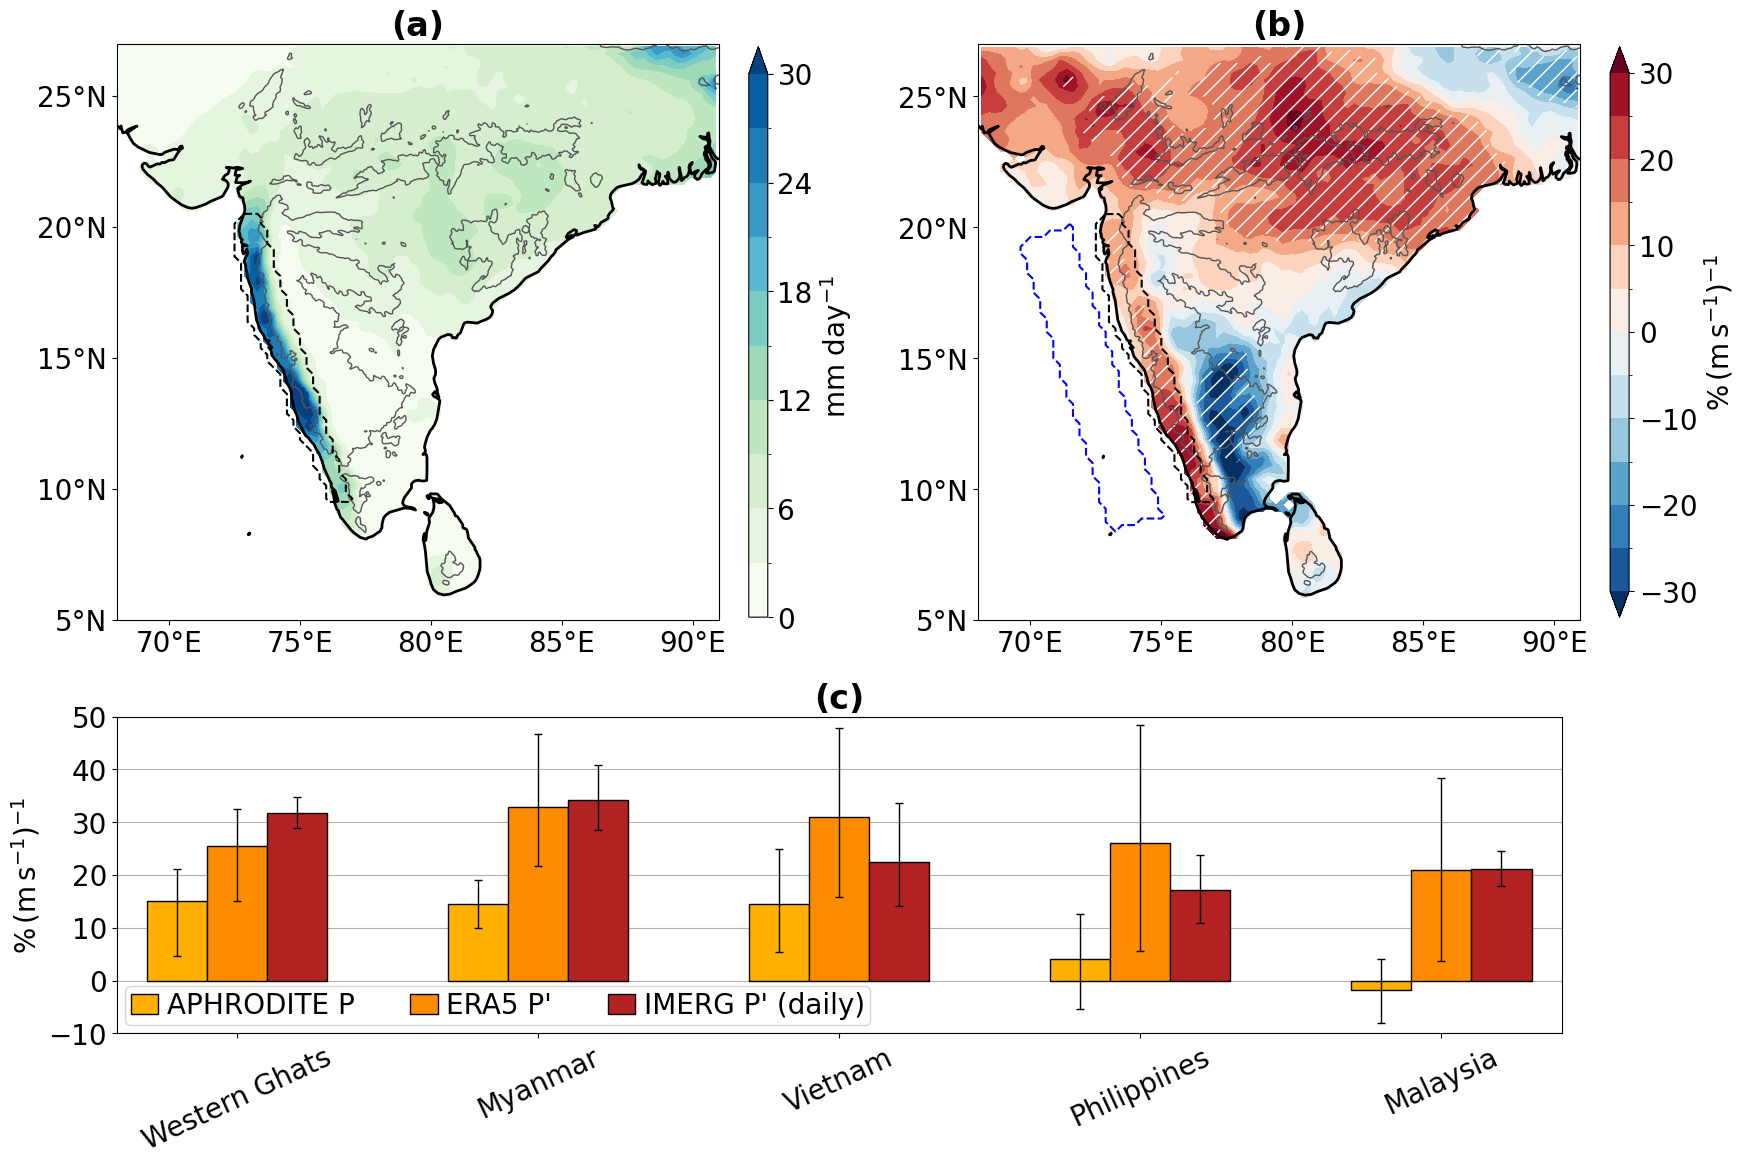

In [104]:
matplotlib.rcParams.update({'font.size':20})
plt.rcParams['hatch.color'] = 'w'

# Create a figure and a set of subplots
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[2, 1], figure=fig)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(gs[1, :])  

# The first row has two panels, each using a cartopy projection PlateCarree
plot_regs([ax1,ax2],Ghats,APHRODITE)

###### Make bar plot ###### 
# set width of bars
nelems   = 3
nregions = len(MRs)
barWidth = 1/(nelems+2)
colors = ['#FFB000','darkorange','firebrick']
labels = [r"APHRODITE P",r"ERA5 P'",r"IMERG P' (daily)"]

# Set position of bar on X axis & plot bar
brs = np.arange(nregions)
for i in range(nelems):
    ax3.bar(brs + i*barWidth, sensitivities[:,i,0], color =colors[i], width = barWidth,
            edgecolor ='k', label = labels[i], yerr=np.abs(sensitivities[:,i,1:]-sensitivities[:,i,:1]).T, zorder=3,capsize=3,error_kw={'linewidth':1})    

# Adding Xticks
ax3.set_ylabel(r"%$\,\left(\text{m}\,\text{s}^{-1}\right)^{-1}$", fontsize = 20)
ax3.set_xticks([r + (nelems-1)/2*barWidth for r in range(nregions)],[MR.Lname for MR in MRs],rotation=25)

handles, labels = ax3.get_legend_handles_labels()
order = [0,1,2]
ax3.legend([handles[idx] for idx in order],[labels[idx] for idx in order],handlelength=1,borderpad=0.2, borderaxespad=0.3,handletextpad=0.3,ncol=3,columnspacing=2,loc=3)

ax3.grid(zorder=0,axis='y')
ax3.set_ylim(-10,50)
ax3.set_yticks(range(-10,51,10))
ax3.set_xlim(-0.2,4.6)

divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size=1., pad=.6,axes_class=plt.Axes)
cax.remove()
###### ###### ###### ###### ###### 

ax1.set_title('(a)',fontweight='bold')
ax2.set_title('(b)',fontweight='bold')
ax3.set_title('(c)',fontweight='bold')
fig.tight_layout()